In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import  sklearn.svm as svm
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
np.random.seed(50)

# 1. Load Dataset 

In [2]:
os.listdir('dataset')

['current_app.csv', 'previous_app.csv']

In [3]:
org_dataset = pd.read_csv('dataset/current_app.csv', na_values= ["N/a", "na", "XNA", np.nan])
org_dataset.head(10)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   
7      100010       0         Cash loans           M            Y   
8      100011       0         Cash loans           F            N   
9      100012       0    Revolving loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   
5               Y             0           99000.0    490495.5      27517.5   
6               Y             1          171000.0   1560726.0      41301.0   
7               Y             0          360000.0   1530000.0      42075.0   
8               Y             0          112500.0   1019610.0      33826.5   
9               Y             0          135000.0    405000.0      20250.0   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   
5  ...                 0                0                0                0   
6  ...                 0                0                0                0   
7  ...                 0                0                0                0   
8  ...                 0                0                0                0   
9  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   
5                        0.0                       0.0   
6                        0.0                       0.0   
7                        0.0                       0.0   
8                        0.0                       0.0   
9                        NaN                       NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   
5                         0.0                        0.0   
6                         0.0                        1.0   
7                         0.0                        0.0   
8                         0.0                        0.0   
9                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0         

In [4]:
org_dataset.shape

(307511, 122)

Notice: the data set has about 307k rows and 122 features (regressors)

# 2. Preprocessing

## 2.1 Detect Outliers And Invalid Values

In [5]:
to_clean_dataset = org_dataset.copy()

### Invalid Values

In [6]:
all_cols = to_clean_dataset.columns

In [7]:
split = len(all_cols)//6
to_clean_dataset[all_cols[:split]].describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  
count      307511.000000  
mean        -4986.120328  
std          3522.886321  
min        -24672.000000  
25%         -7479.500000  
50%         -4504.000000  
75%         -2010.000000  
max             0.000000

In [8]:
to_clean_dataset[all_cols[split:split*2]].describe()

DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  FLAG_EMP_PHONE  \
count    307511.000000  104582.000000  307511.000000   307511.000000   
mean      -2994.202373      12.061091       0.999997        0.819889   
std        1509.450419      11.944812       0.001803        0.384280   
min       -7197.000000       0.000000       0.000000        0.000000   
25%       -4299.000000       5.000000       1.000000        1.000000   
50%       -3254.000000       9.000000       1.000000        1.000000   
75%       -1720.000000      15.000000       1.000000        1.000000   
max           0.000000      91.000000       1.000000        1.000000   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  \
count    307511.000000     307511.000000  307511.000000  307511.000000   
mean          0.199368          0.998133       0.281066       0.056720   
std           0.399526          0.043164       0.449521       0.231307   
min           0.000000          0.000000       0.000000       0.000000   
25%           0.000000          1.000000       0.000000       0.000000   
50%           0.000000          1.000000       0.000000       0.000000   
75%           0.000000          1.000000       1.000000       0.000000   
max           1.000000          1.000000       1.000000       1.000000   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count    307509.000000         307511.000000                307511.000000   
mean          2.152665              2.052463                     2.031521   
std           0.910682              0.509034                     0.502737   
min           1.000000              1.000000                     1.000000   
25%           2.000000              2.000000                     2.000000   
50%           2.000000              2.000000                     2.000000   
75%           3.000000              2.000000                     2.000000   
max          20.000000              3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            307511.000000               307511.000000   
mean                 12.063419                    0.015144   
std                   3.265832                    0.122126   
min                   0.000000                    0.000000   
25%                  10.000000                    0.000000   
50%                  12.000000                    0.000000   
75%                  14.000000                    0.000000   
max                  23.000000                    1.000000   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
count               307511.000000                307511.000000   
mean                     0.050769                     0.040659   
std                      0.219526                     0.197499   
min                      0.000000                     0.000000   
25%                      0.000000                     0.000000   
50%                      0.000000                     0.000000   
75%                      0.000000                     0.000000   
max                      1.000000                     1.000000   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  
count           307511.000000           307511.000000            307511.000000  
mean                 0.078173                0.230454                 0.179555  
std                  0.268444                0.421124                 0.383817  
min                  0.000000                0.000000                 0.000000  
25%                  0.000000                0.000000                 0.000000  
50%                  0.000000                0.000000                 0.000000  
75%                  0.000000                0.000000                 0.000000  
max                  1.000000                1.000000                 1.000000

In [9]:
to_clean_dataset[all_cols[split*2:split*3]].describe()

EXT_SOURCE_1  EXT_SOURCE_2   EXT_SOURCE_3  APARTMENTS_AVG  \
count  134133.000000  3.068510e+05  246546.000000    151450.00000   
mean        0.502130  5.143927e-01       0.510853         0.11744   
std         0.211062  1.910602e-01       0.194844         0.10824   
min         0.014568  8.173617e-08       0.000527         0.00000   
25%         0.334007  3.924574e-01       0.370650         0.05770   
50%         0.505998  5.659614e-01       0.535276         0.08760   
75%         0.675053  6.636171e-01       0.669057         0.14850   
max         0.962693  8.549997e-01       0.896010         1.00000   

       BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  \
count     127568.000000                157504.000000    103023.000000   
mean           0.088442                     0.977735         0.752471   
std            0.082438                     0.059223         0.113280   
min            0.000000                     0.000000         0.000000   
25%            0.044200                     0.976700         0.687200   
50%            0.076300                     0.981600         0.755200   
75%            0.112200                     0.986600         0.823200   
max            1.000000                     1.000000         1.000000   

       COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
count    92646.000000  143620.000000  152683.000000  154491.000000   
mean         0.044621       0.078942       0.149725       0.226282   
std          0.076036       0.134576       0.100049       0.144641   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.007800       0.000000       0.069000       0.166700   
50%          0.021100       0.000000       0.137900       0.166700   
75%          0.051500       0.120000       0.206900       0.333300   
max          1.000000       1.000000       1.000000       1.000000   

       FLOORSMIN_AVG   LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
count   98869.000000  124921.000000          97312.000000   153161.000000   
mean        0.231894       0.066333              0.100775        0.107399   
std         0.161380       0.081184              0.092576        0.110565   
min         0.000000       0.000000              0.000000        0.000000   
25%         0.083300       0.018700              0.050400        0.045300   
50%         0.208300       0.048100              0.075600        0.074500   
75%         0.375000       0.085600              0.121000        0.129900   
max         1.000000       1.000000              1.000000        1.000000   

       NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
count             93997.000000      137829.000000    151450.000000   
mean                  0.008809           0.028358         0.114231   
std                   0.047732           0.069523         0.107936   
min                   0.000000           0.000000         0.000000   
25%                   0.000000           0.000000         0.052500   
50%                   0.000000           0.003600         0.084000   
75%                   0.003900           0.027700         0.143900   
max                   1.000000           1.000000         1.000000   

       BASEMENTAREA_MODE  
count      127568.000000  
mean            0.087543  
std             0.084307  
min             0.000000  
25%             0.040700  
50%             0.074600  
75%             0.112400  
max             1.000000

In [10]:
to_clean_dataset[all_cols[split*3:split*4]].describe()

YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \
count                 157504.000000     103023.000000     92646.000000   
mean                       0.977065          0.759637         0.042553   
std                        0.064575          0.110111         0.074445   
min                        0.000000          0.000000         0.000000   
25%                        0.976700          0.699400         0.007200   
50%                        0.981600          0.764800         0.019000   
75%                        0.986600          0.823600         0.049000   
max                        1.000000          1.000000         1.000000   

       ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  \
count   143620.000000   152683.000000   154491.000000    98869.000000   
mean         0.074490        0.145193        0.222315        0.228058   
std          0.132256        0.100977        0.143709        0.161160   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.069000        0.166700        0.083300   
50%          0.000000        0.137900        0.166700        0.208300   
75%          0.120800        0.206900        0.333300        0.375000   
max          1.000000        1.000000        1.000000        1.000000   

       LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
count  124921.000000           97312.000000    153161.000000   
mean        0.064958               0.105645         0.105975   
std         0.081750               0.097880         0.111845   
min         0.000000               0.000000         0.000000   
25%         0.016600               0.054200         0.042700   
50%         0.045800               0.077100         0.073100   
75%         0.084100               0.131300         0.125200   
max         1.000000               1.000000         1.000000   

       NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
count              93997.000000       137829.000000    151450.000000   
mean                   0.008076            0.027022         0.117850   
std                    0.046276            0.070254         0.109076   
min                    0.000000            0.000000         0.000000   
25%                    0.000000            0.000000         0.058300   
50%                    0.000000            0.001100         0.086400   
75%                    0.003900            0.023100         0.148900   
max                    1.000000            1.000000         1.000000   

       BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
count      127568.000000                 157504.000000     103023.000000   
mean            0.087955                      0.977752          0.755746   
std             0.082179                      0.059897          0.112066   
min             0.000000                      0.000000          0.000000   
25%             0.043700                      0.976700          0.691400   
50%             0.075800                      0.981600          0.758500   
75%             0.111600                      0.986600          0.825600   
max             1.000000                      1.000000          1.000000   

       COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  
count     92646.000000   143620.000000   152683.000000   154491.000000  
mean          0.044595        0.078078        0.149213        0.225897  
std           0.076144        0.134467        0.100368        0.145067  
min           0.000000        0.000000        0.000000        0.000000  
25%           0.007900        0.000000        0.069000        0.166700  
50%           0.020800        0.000000        0.137900        0.166700  
75%           0.051300        0.120000        0.206900        0.333300  
max           1.000000        1.000000        1.000000        1.000000

In [11]:
to_clean_dataset[all_cols[split*4:split*5]].describe()

FLOORSMIN_MEDI  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  \
count    98869.000000  124921.000000           97312.000000    153161.000000   
mean         0.231625       0.067169               0.101954         0.108607   
std          0.161934       0.082167               0.093642         0.112260   
min          0.000000       0.000000               0.000000         0.000000   
25%          0.083300       0.018700               0.051300         0.045700   
50%          0.208300       0.048700               0.076100         0.074900   
75%          0.375000       0.086800               0.123100         0.130300   
max          1.000000       1.000000               1.000000         1.000000   

       NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI  TOTALAREA_MODE  \
count              93997.000000       137829.000000   159080.000000   
mean                   0.008651            0.028236        0.102547   
std                    0.047415            0.070166        0.107462   
min                    0.000000            0.000000        0.000000   
25%                    0.000000            0.000000        0.041200   
50%                    0.000000            0.003100        0.068800   
75%                    0.003900            0.026600        0.127600   
max                    1.000000            1.000000        1.000000   

       OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
count             306490.000000             306490.000000   
mean                   1.422245                  0.143421   
std                    2.400989                  0.446698   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    2.000000                  0.000000   
max                  348.000000                 34.000000   

       OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
count             306490.000000             306490.000000   
mean                   1.405292                  0.100049   
std                    2.379803                  0.362291   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    2.000000                  0.000000   
max                  344.000000                 24.000000   

       DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
count           307510.000000    307511.000000    307511.000000   
mean              -962.858788         0.000042         0.710023   
std                826.808487         0.006502         0.453752   
min              -4292.000000         0.000000         0.000000   
25%              -1570.000000         0.000000         0.000000   
50%               -757.000000         0.000000         1.000000   
75%               -274.000000         0.000000         1.000000   
max                  0.000000         1.000000         1.000000   

       FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  
count    307511.000000    307511.000000  
mean          0.000081         0.015115  
std           0.009016         0.122010  
min           0.000000         0.000000  
25%           0.000000         0.000000  
50%           0.000000         0.000000  
75%           0.000000         0.000000  
max           1.000000         1.000000

In [12]:
to_clean_dataset[all_cols[split*5:split*6]].describe()

FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
count    307511.000000    307511.000000    307511.000000    307511.000000   
mean          0.088055         0.000192         0.081376         0.003896   
std           0.283376         0.013850         0.273412         0.062295   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.000000         0.000000         0.000000         0.000000   
50%           0.000000         0.000000         0.000000         0.000000   
75%           0.000000         0.000000         0.000000         0.000000   
max           1.000000         1.000000         1.000000         1.000000   

       FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.000023          0.003912          0.000007          0.003525   
std            0.004771          0.062424          0.002550          0.059268   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  \
count     307511.000000      307511.00000     307511.000000     307511.000000   
mean           0.002936           0.00121          0.009928          0.000267   
std            0.054110           0.03476          0.099144          0.016327   
min            0.000000           0.00000          0.000000          0.000000   
25%            0.000000           0.00000          0.000000          0.000000   
50%            0.000000           0.00000          0.000000          0.000000   
75%            0.000000           0.00000          0.000000          0.000000   
max            1.000000           1.00000          1.000000          1.000000   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  
count               265992.000000              265992.000000  
mean                     0.034362                   0.267395  
std                      0.204685                   0.916002  
min                      0.000000                   0.000000  
25%                      0.000000                   0.000000  
50%                      0.000000                   0.000000  
75%                      0.000000                   0.000000  
max                      8.000000         

In [13]:
to_clean_dataset[all_cols[split*6:]].describe()

AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR
count              265992.000000               265992.000000
mean                    0.265474                    1.899974
std                     0.794056                    1.869295
min                     0.000000                    0.000000
25%                     0.000000                    0.000000
50%                     0.000000                    1.000000
75%                     0.000000                    3.000000
max                   261.000000                   25.000000

From the above description we can find some columns having invalid values such as DAYS_BIRTH, DAYS_EMPLOYED,DAYS_REGISTRATION, DAYS_ID_PUBLISH, DAYS_LAST_PHONE_CHANGE have negative values while they should be positive, so we will replace those values with their absolute

In [14]:
# remove negative sign of features with false negative
to_clean_dataset['DAYS_BIRTH'] = abs(to_clean_dataset['DAYS_BIRTH'] )
to_clean_dataset['DAYS_REGISTRATION'] = abs(to_clean_dataset['DAYS_REGISTRATION'] )
to_clean_dataset['DAYS_ID_PUBLISH'] = abs(to_clean_dataset['DAYS_ID_PUBLISH'] )
to_clean_dataset['DAYS_EMPLOYED'] = abs(to_clean_dataset['DAYS_EMPLOYED'] )
to_clean_dataset['DAYS_LAST_PHONE_CHANGE'] = abs(to_clean_dataset['DAYS_LAST_PHONE_CHANGE'] )

### Outliers

In [15]:
to_clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [16]:
continuous_cols = to_clean_dataset.columns[to_clean_dataset.dtypes != object]

In [17]:
# draw box plot of out (TARGET) vs continuous     
def cont_vs_out(out, cont_col, data):
    plt.figure()
    sns.boxplot(data = data, x= out, y = cont_col, order=out.value_counts().index)
    plt.xticks(rotation = 90)
    plt.show()
    plt.close()

SK_ID_CURR


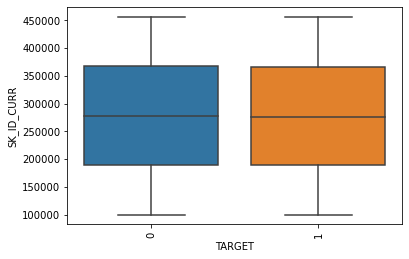

TARGET


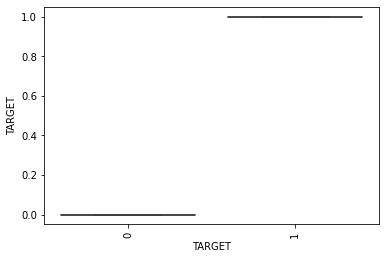

CNT_CHILDREN


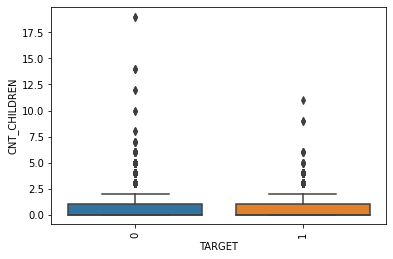

AMT_INCOME_TOTAL


AMT_CREDIT


AMT_ANNUITY


AMT_GOODS_PRICE


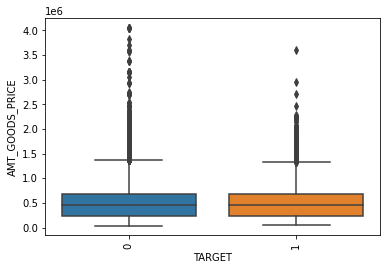

REGION_POPULATION_RELATIVE


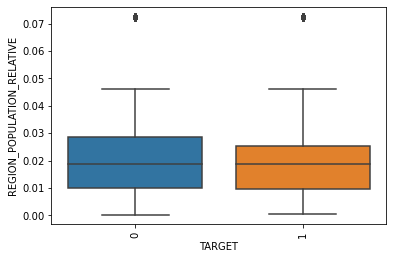

DAYS_BIRTH


DAYS_EMPLOYED


DAYS_REGISTRATION


DAYS_ID_PUBLISH


OWN_CAR_AGE


FLAG_MOBIL


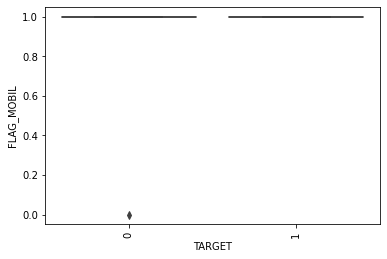

FLAG_EMP_PHONE


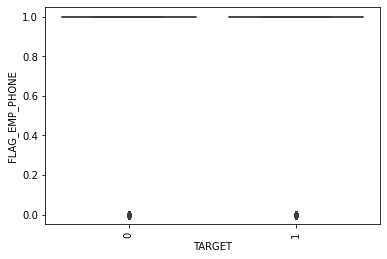

FLAG_WORK_PHONE


FLAG_CONT_MOBILE


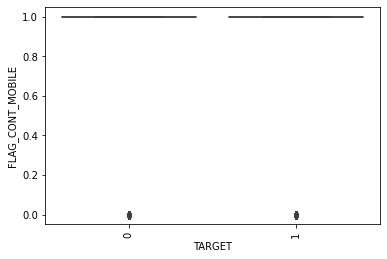

FLAG_PHONE


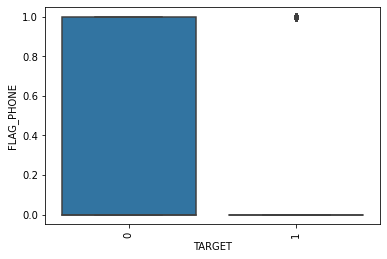

FLAG_EMAIL


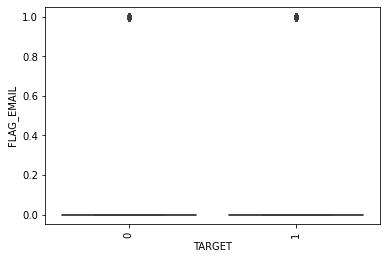

CNT_FAM_MEMBERS


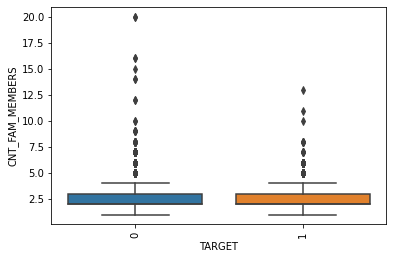

REGION_RATING_CLIENT


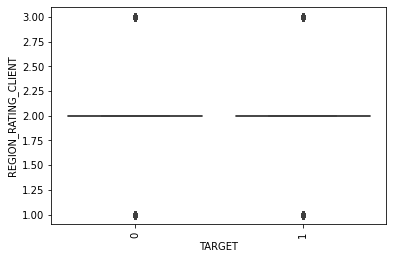

REGION_RATING_CLIENT_W_CITY


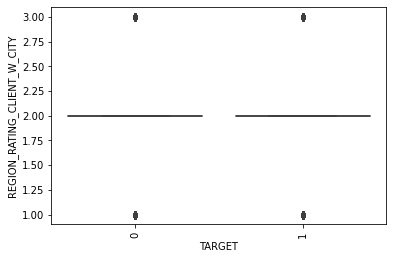

HOUR_APPR_PROCESS_START


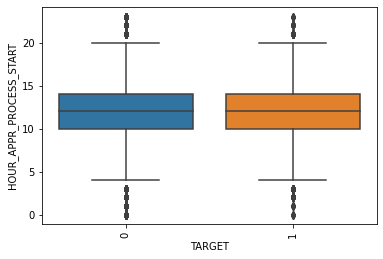

REG_REGION_NOT_LIVE_REGION


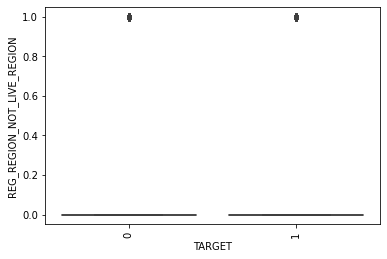

REG_REGION_NOT_WORK_REGION


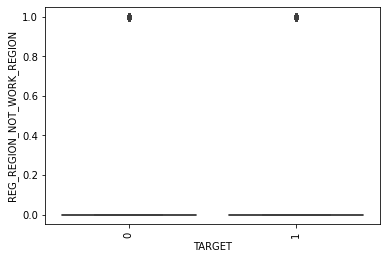

LIVE_REGION_NOT_WORK_REGION


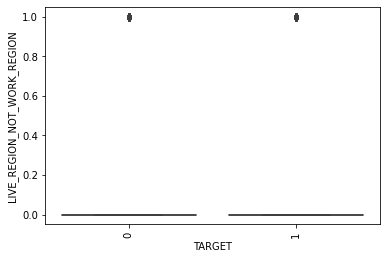

REG_CITY_NOT_LIVE_CITY


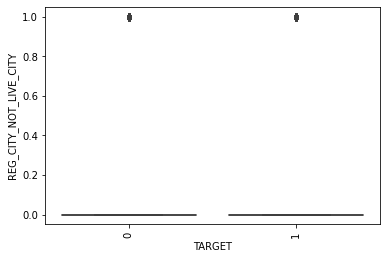

REG_CITY_NOT_WORK_CITY


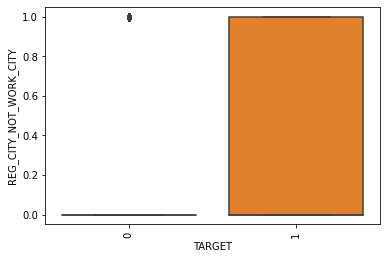

LIVE_CITY_NOT_WORK_CITY


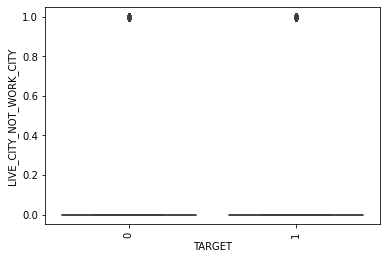

EXT_SOURCE_1


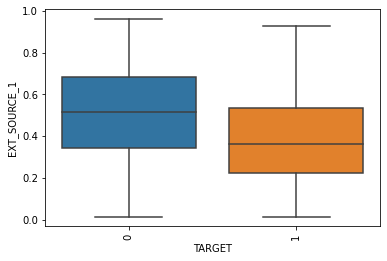

EXT_SOURCE_2


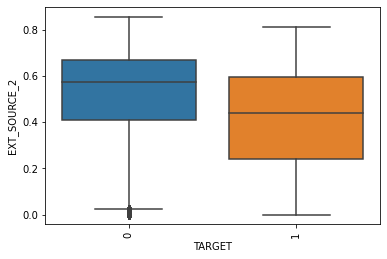

EXT_SOURCE_3


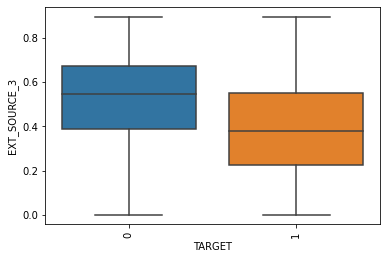

APARTMENTS_AVG


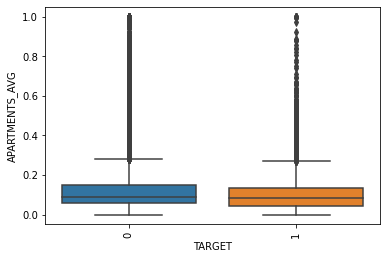

BASEMENTAREA_AVG


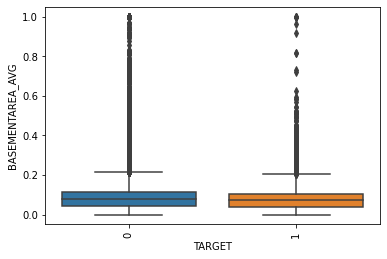

YEARS_BEGINEXPLUATATION_AVG


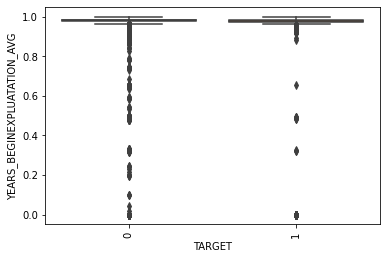

YEARS_BUILD_AVG


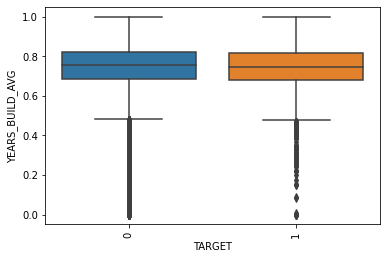

COMMONAREA_AVG


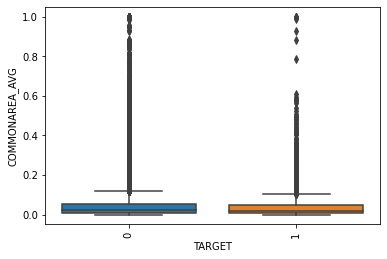

ELEVATORS_AVG


ENTRANCES_AVG


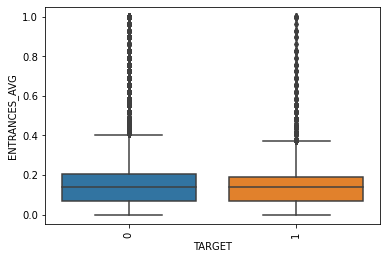

FLOORSMAX_AVG


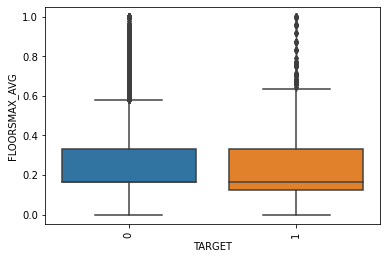

FLOORSMIN_AVG


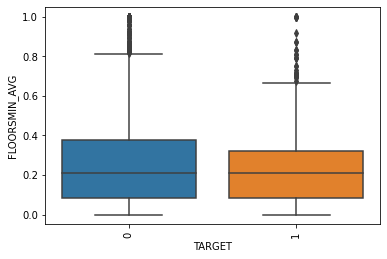

LANDAREA_AVG


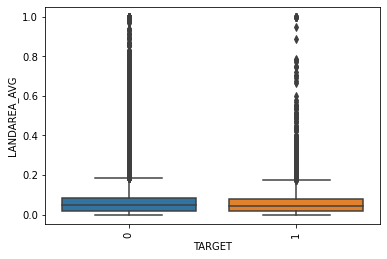

LIVINGAPARTMENTS_AVG


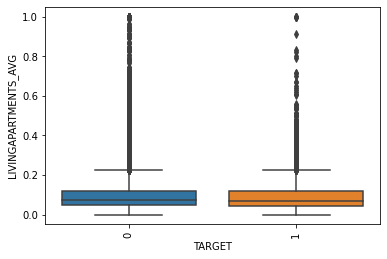

LIVINGAREA_AVG


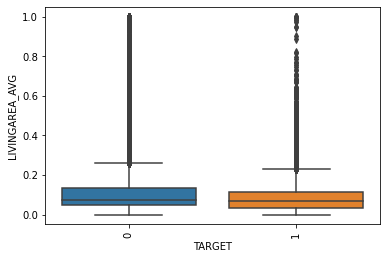

NONLIVINGAPARTMENTS_AVG


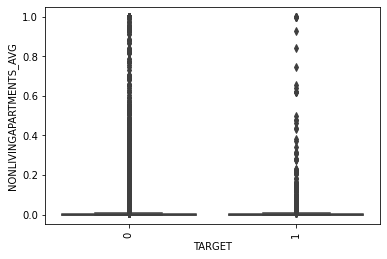

NONLIVINGAREA_AVG


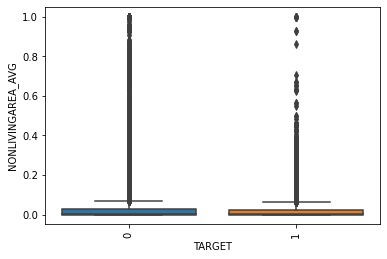

APARTMENTS_MODE


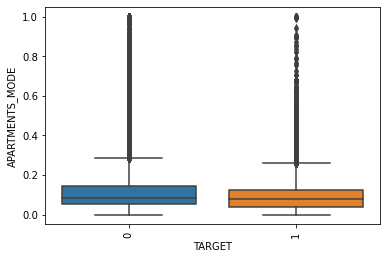

BASEMENTAREA_MODE


YEARS_BEGINEXPLUATATION_MODE


YEARS_BUILD_MODE


COMMONAREA_MODE


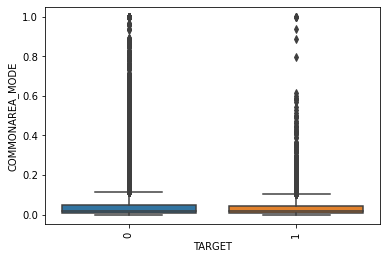

ELEVATORS_MODE


ENTRANCES_MODE


FLOORSMAX_MODE


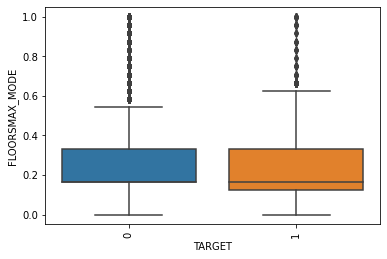

FLOORSMIN_MODE


LANDAREA_MODE


LIVINGAPARTMENTS_MODE


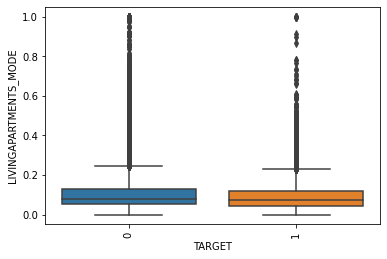

LIVINGAREA_MODE


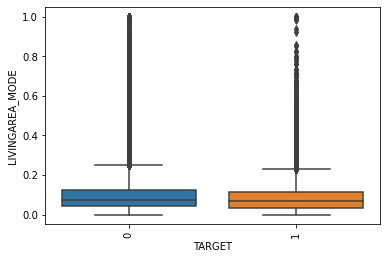

NONLIVINGAPARTMENTS_MODE


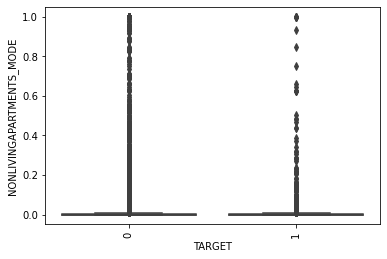

NONLIVINGAREA_MODE


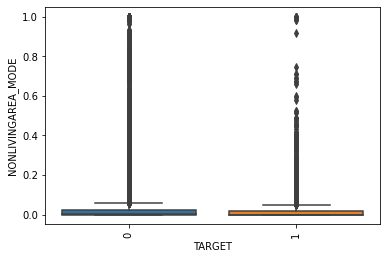

APARTMENTS_MEDI


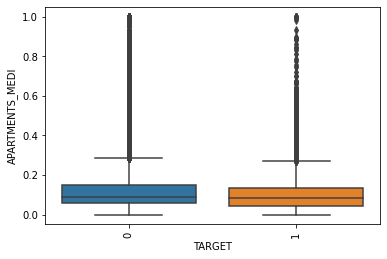

BASEMENTAREA_MEDI


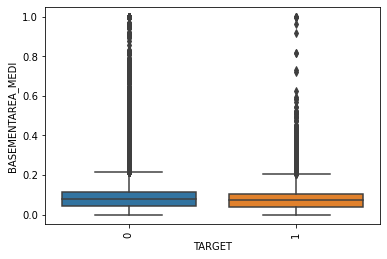

YEARS_BEGINEXPLUATATION_MEDI


YEARS_BUILD_MEDI


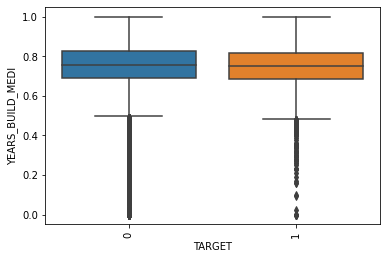

COMMONAREA_MEDI


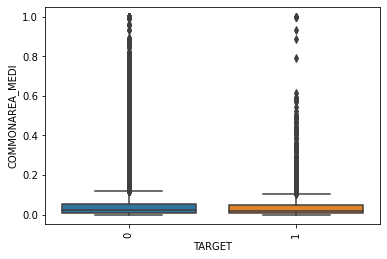

ELEVATORS_MEDI


ENTRANCES_MEDI


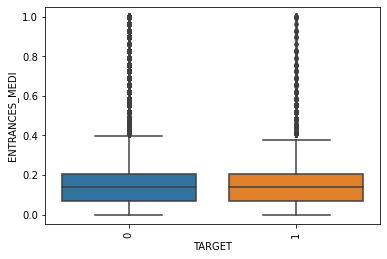

FLOORSMAX_MEDI


FLOORSMIN_MEDI


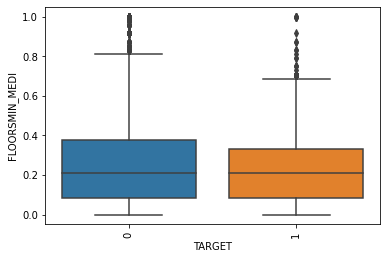

LANDAREA_MEDI


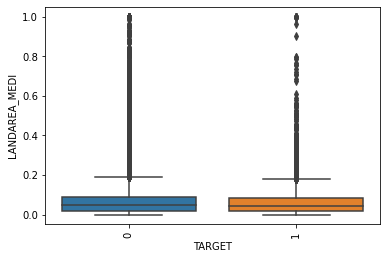

LIVINGAPARTMENTS_MEDI


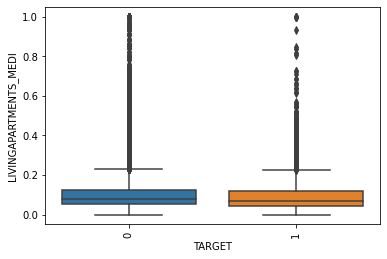

LIVINGAREA_MEDI


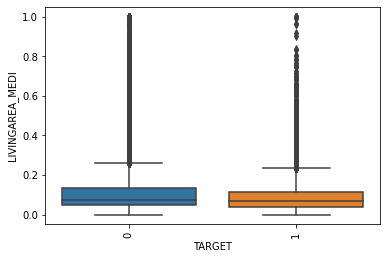

NONLIVINGAPARTMENTS_MEDI


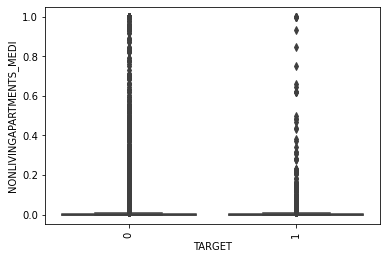

NONLIVINGAREA_MEDI


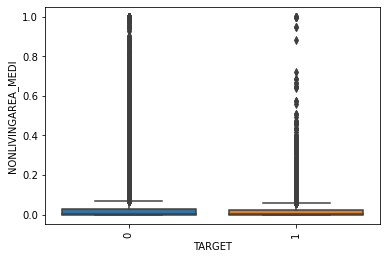

TOTALAREA_MODE


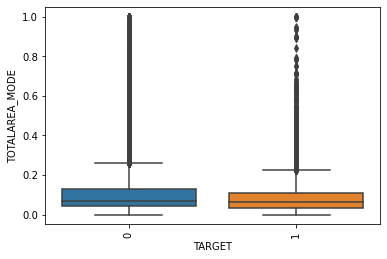

OBS_30_CNT_SOCIAL_CIRCLE


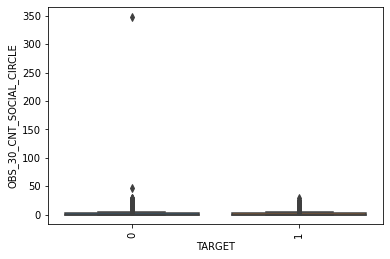

DEF_30_CNT_SOCIAL_CIRCLE


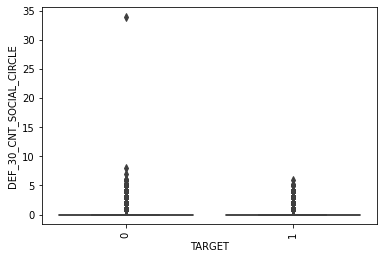

OBS_60_CNT_SOCIAL_CIRCLE


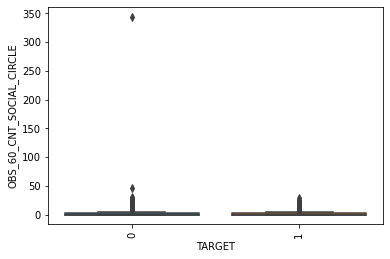

DEF_60_CNT_SOCIAL_CIRCLE


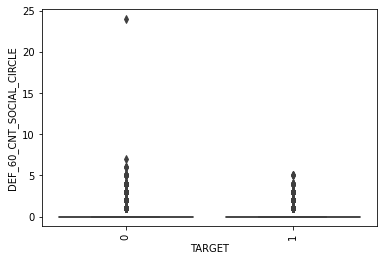

DAYS_LAST_PHONE_CHANGE


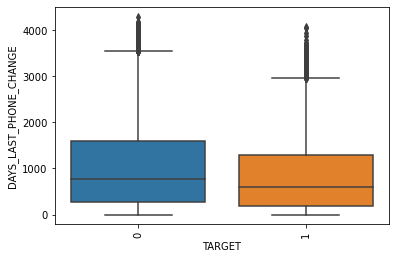

FLAG_DOCUMENT_2


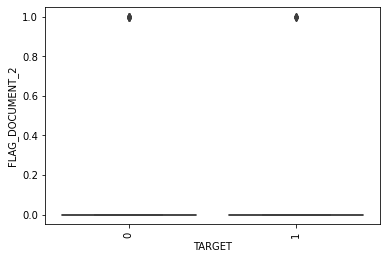

FLAG_DOCUMENT_3


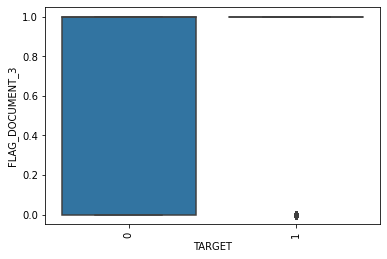

FLAG_DOCUMENT_4


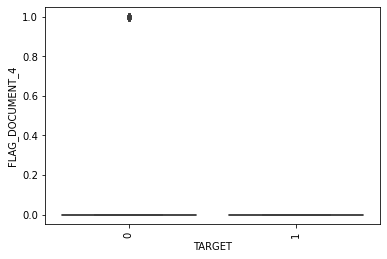

FLAG_DOCUMENT_5


FLAG_DOCUMENT_6


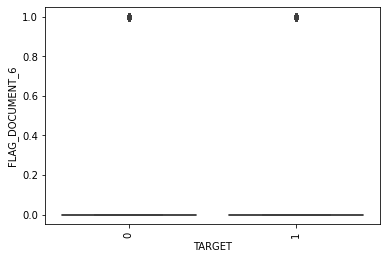

FLAG_DOCUMENT_7


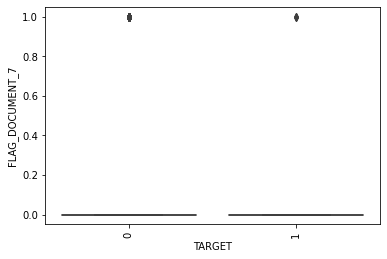

FLAG_DOCUMENT_8


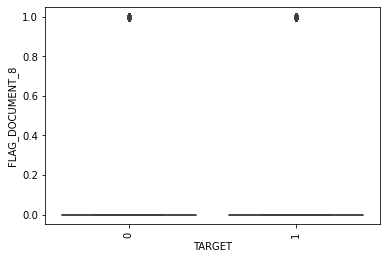

FLAG_DOCUMENT_9


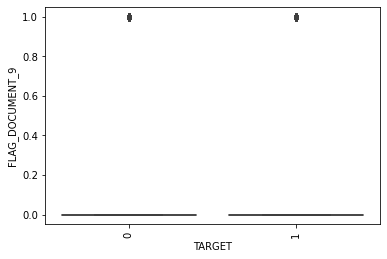

FLAG_DOCUMENT_10


FLAG_DOCUMENT_11


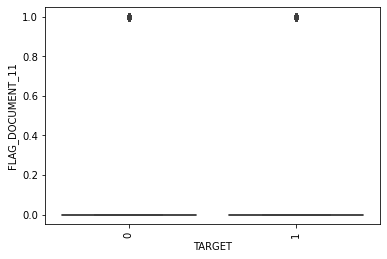

FLAG_DOCUMENT_12


FLAG_DOCUMENT_13


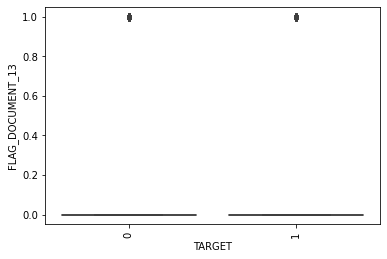

FLAG_DOCUMENT_14


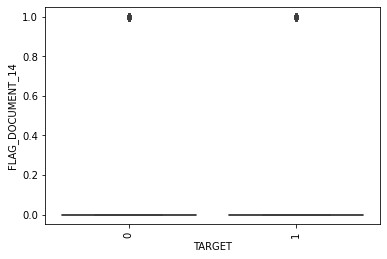

FLAG_DOCUMENT_15


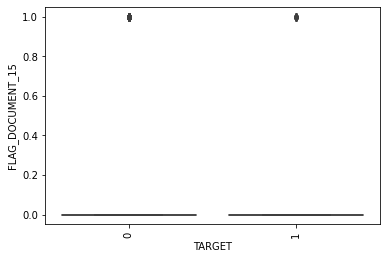

FLAG_DOCUMENT_16


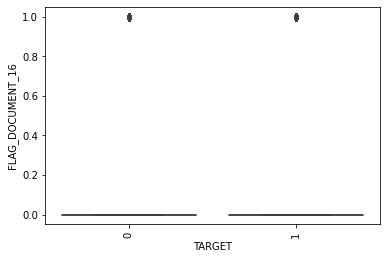

FLAG_DOCUMENT_17


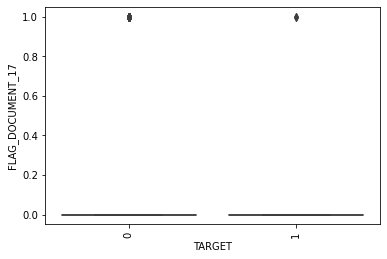

FLAG_DOCUMENT_18


FLAG_DOCUMENT_19


FLAG_DOCUMENT_20


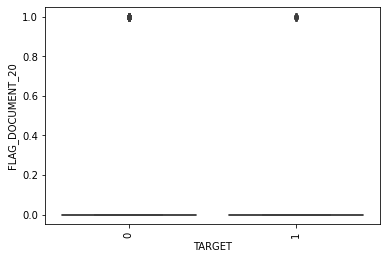

FLAG_DOCUMENT_21


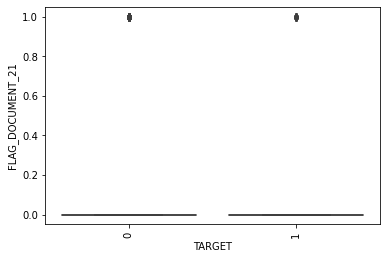

AMT_REQ_CREDIT_BUREAU_HOUR


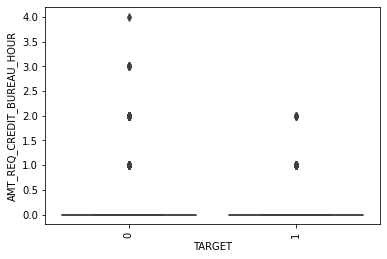

AMT_REQ_CREDIT_BUREAU_DAY


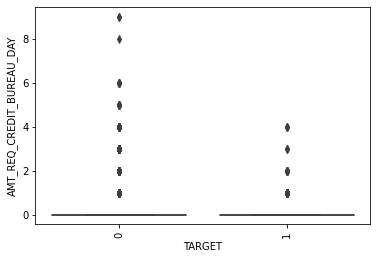

AMT_REQ_CREDIT_BUREAU_WEEK


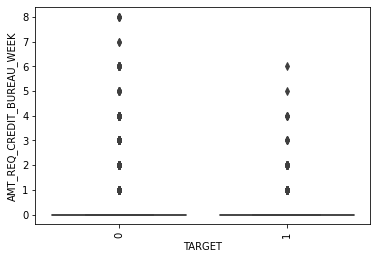

AMT_REQ_CREDIT_BUREAU_MON


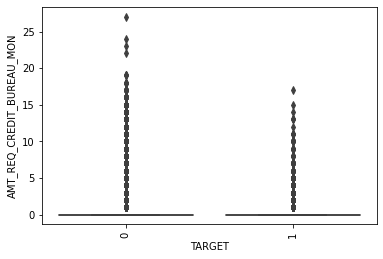

AMT_REQ_CREDIT_BUREAU_QRT


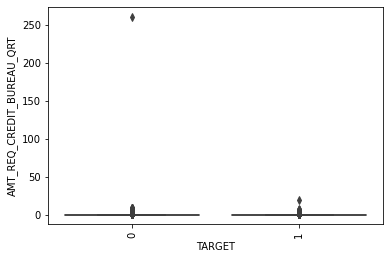

AMT_REQ_CREDIT_BUREAU_YEAR


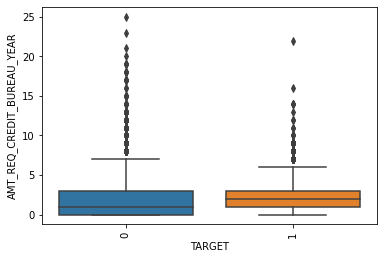

In [18]:
Y = to_clean_dataset['TARGET']
for j in range(len(continuous_cols)):
    print(continuous_cols[j])
    cont_vs_out(Y, continuous_cols[j], to_clean_dataset)

Notice: AMT_INCOME_TOTAL, REGION_POPULATION_RELATIVE, DAYS_EMPLOYED, CNT_FAM_MEMBERS, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, AMT_REQ_CREDIT_BUREAU_QRT.
All these have outliers that needs to be removed before applying any processing on the columns

In [19]:
# remove outliers
to_clean_dataset.drop((to_clean_dataset[to_clean_dataset.AMT_REQ_CREDIT_BUREAU_QRT > 50].index), axis = 0, inplace= True)
to_clean_dataset.drop((to_clean_dataset[to_clean_dataset.REGION_POPULATION_RELATIVE > 0.05].index), axis = 0, inplace= True)
to_clean_dataset.drop((to_clean_dataset[to_clean_dataset.OBS_30_CNT_SOCIAL_CIRCLE > 40].index), axis = 0, inplace= True)
to_clean_dataset.drop((to_clean_dataset[to_clean_dataset.DEF_30_CNT_SOCIAL_CIRCLE > 40].index), axis = 0, inplace= True)
to_clean_dataset.drop((to_clean_dataset[to_clean_dataset.OBS_60_CNT_SOCIAL_CIRCLE > 40].index), axis = 0, inplace= True)
to_clean_dataset.drop((to_clean_dataset[to_clean_dataset.DEF_60_CNT_SOCIAL_CIRCLE > 10].index), axis = 0, inplace= True)
to_clean_dataset.drop((to_clean_dataset[to_clean_dataset.AMT_REQ_CREDIT_BUREAU_QRT > 200].index), axis = 0, inplace= True)
to_clean_dataset.drop((to_clean_dataset[to_clean_dataset.AMT_INCOME_TOTAL > 0.2e6].index), axis = 0, inplace= True)
to_clean_dataset.drop((to_clean_dataset[to_clean_dataset.CNT_FAM_MEMBERS > 10].index), axis = 0, inplace= True)
to_clean_dataset.drop((to_clean_dataset[to_clean_dataset.DAYS_EMPLOYED > 50000].index), axis = 0, inplace= True)

## 2.1 visulalize and analyze Nan Values in dataset

In [20]:
to_clean_dataset.isnull().any().any()

True

Notice: Data has Nan Values

<AxesSubplot:>

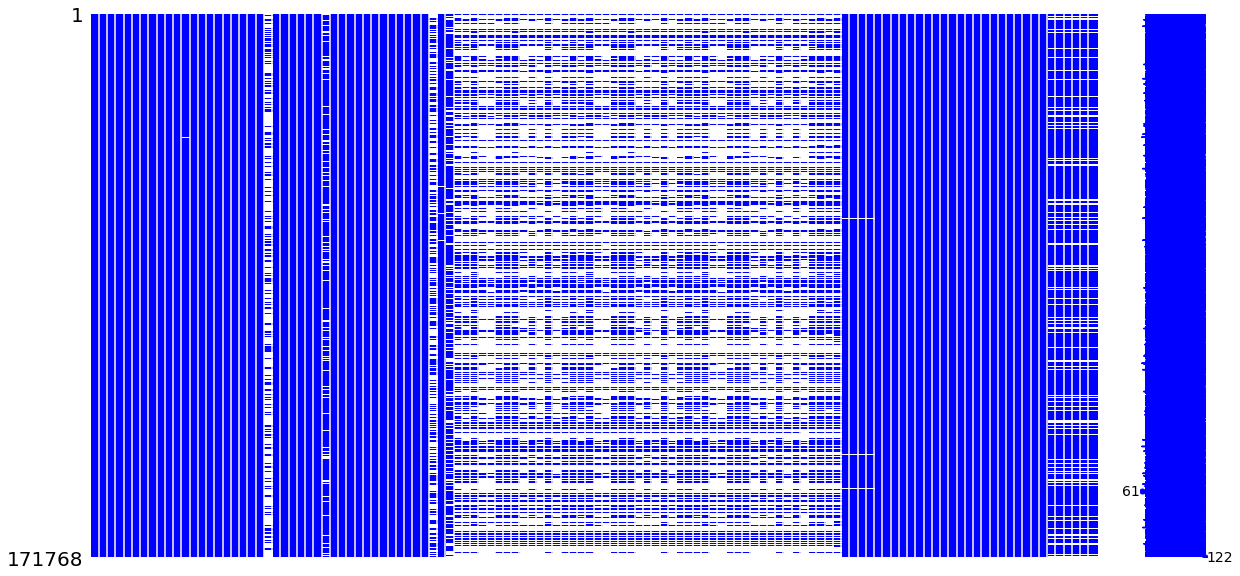

In [21]:
# Visualize Nan values in data set using Missingno Library
msno.matrix(to_clean_dataset,figsize=(20,10),color=(0, 0 ,1))

Notice: the dataset has many rows with a lot of Nan values<br> 
Recommended 1: to drop columns with nan values > 50% 

In [22]:
# drop columns with Nan values > 50%
to_clean_dataset.dropna(thresh= to_clean_dataset.shape[0]* 0.5, axis = 1, inplace=True )
to_clean_dataset.shape

(171768, 73)

Notice: the number of columns decreased from 122 to 73 <br>
when dropped columns with nan values of percentage > 50% <br> 


Recommended 2: fill columns with Nan values < 13% with mean or mode depending on column type 

In [23]:
# get columns with <= 13% 
dirty_cols =to_clean_dataset.columns[to_clean_dataset.isnull().sum(axis = 0) <= (0.13 * to_clean_dataset.shape[0])]

In [24]:
to_clean_dataset[dirty_cols].head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   
5               Y             0           99000.0    490495.5      27517.5   
6               Y             1          171000.0   1560726.0      41301.0   

   ...  FLAG_DOCUMENT_12 FLAG_DOCUMENT_13 FLAG_DOCUMENT_14 FLAG_DOCUMENT_15  \
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   
5  ...                 0                0                0                0   
6  ...                 0                0                1                0   

  FLAG_DOCUMENT_16 FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  \
2                0                0                 0                 0   
3                0                0                 0                 0   
4                0                0                 0                 0   
5                0                0                 0                 0   
6                0                0                 0                 0   

   FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  
2                 0                 0  
3                 0                 0  
4                 0                 0  
5                 0                 0  
6                 0                 0  

[5 rows x 65 columns]

Notice: We will replace with mode values for categorical columns and mean for continous columns<br> 
but for this we will first check if there are any outliers so that the mean values would be correct

In [25]:
to_clean_dataset[dirty_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171768 entries, 2 to 307510
Data columns (total 65 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   171768 non-null  int64  
 1   TARGET                       171768 non-null  int64  
 2   NAME_CONTRACT_TYPE           171768 non-null  object 
 3   CODE_GENDER                  171766 non-null  object 
 4   FLAG_OWN_CAR                 171768 non-null  object 
 5   FLAG_OWN_REALTY              171768 non-null  object 
 6   CNT_CHILDREN                 171768 non-null  int64  
 7   AMT_INCOME_TOTAL             171768 non-null  float64
 8   AMT_CREDIT                   171768 non-null  float64
 9   AMT_ANNUITY                  171761 non-null  float64
 10  AMT_GOODS_PRICE              171553 non-null  float64
 11  NAME_TYPE_SUITE              171030 non-null  object 
 12  NAME_INCOME_TYPE             171768 non-null  object 
 13 

In [26]:
dirty_cat = [col for col in dirty_cols if (len(to_clean_dataset[col].unique()) == 2) or ((to_clean_dataset[col].dtype != np.int64) and (to_clean_dataset[col].dtype != np.float64))]
dirty_cont = np.setdiff1d(dirty_cols, dirty_cat)

In [27]:
# fill Nan of Categorical values with mode value
for col in dirty_cat: 
    to_clean_dataset[col].fillna(value= to_clean_dataset[col].mode()[0] ,inplace = True )

    # fill Nan of Continous Columns with mean value
for col in dirty_cont: 
    to_clean_dataset[col].fillna(value= to_clean_dataset[col].mean() ,inplace = True )

Notice: For columns with Nan values > 13% and <50% we will drop rows containing Nan values

In [28]:
# drop remaining rows with Nan values 
to_clean_dataset.dropna(inplace=True)
# check if dataset is dirty
to_clean_dataset.isnull().any().any()

False

Notice: Now our dataset has no Nan values

In [29]:
# remove SK_ID_CURR Columns from dataset as it won't be useful for our problem 
to_clean_dataset = to_clean_dataset.drop(labels=['SK_ID_CURR'], axis = 1)

In [30]:
to_clean_dataset.shape

(113206, 72)

In [31]:
clean_dataset = to_clean_dataset.copy()

Notice: Considering the very large amount of features that won't be usefull for classification<br>  
We will apply bivariate analysis first to remove redundant features<br> 
then We will analyize the usefull features

# 3. Bivariate Analysis
## 3.1 Continuous Vs Continuous
Remove features that are correlated

In [32]:
# check types of columns 
clean_dataset.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [34]:
# select columns with only two categories (binary)
binary_features = [col for col in clean_dataset.columns if clean_dataset[col].unique().size <= 2]

In [35]:
# select continuous features 
cont_cols = clean_dataset.columns[(clean_dataset.dtypes == 'int64')|(clean_dataset.dtypes == 'float64')]
# remove binary features from result 
cont_cols = [col for col in cont_cols if col not in binary_features]

In [36]:
# get columns with correlation > threshold
def get_correlated(cor, thr):
    corr_idx = []
    for i in range(cor.shape[0]): 
        for j in range(i, cor.shape[1]): 
            if i != j and abs(cor[i,j]) >= thr:
                corr_idx.append((i,j))
    
    return corr_idx

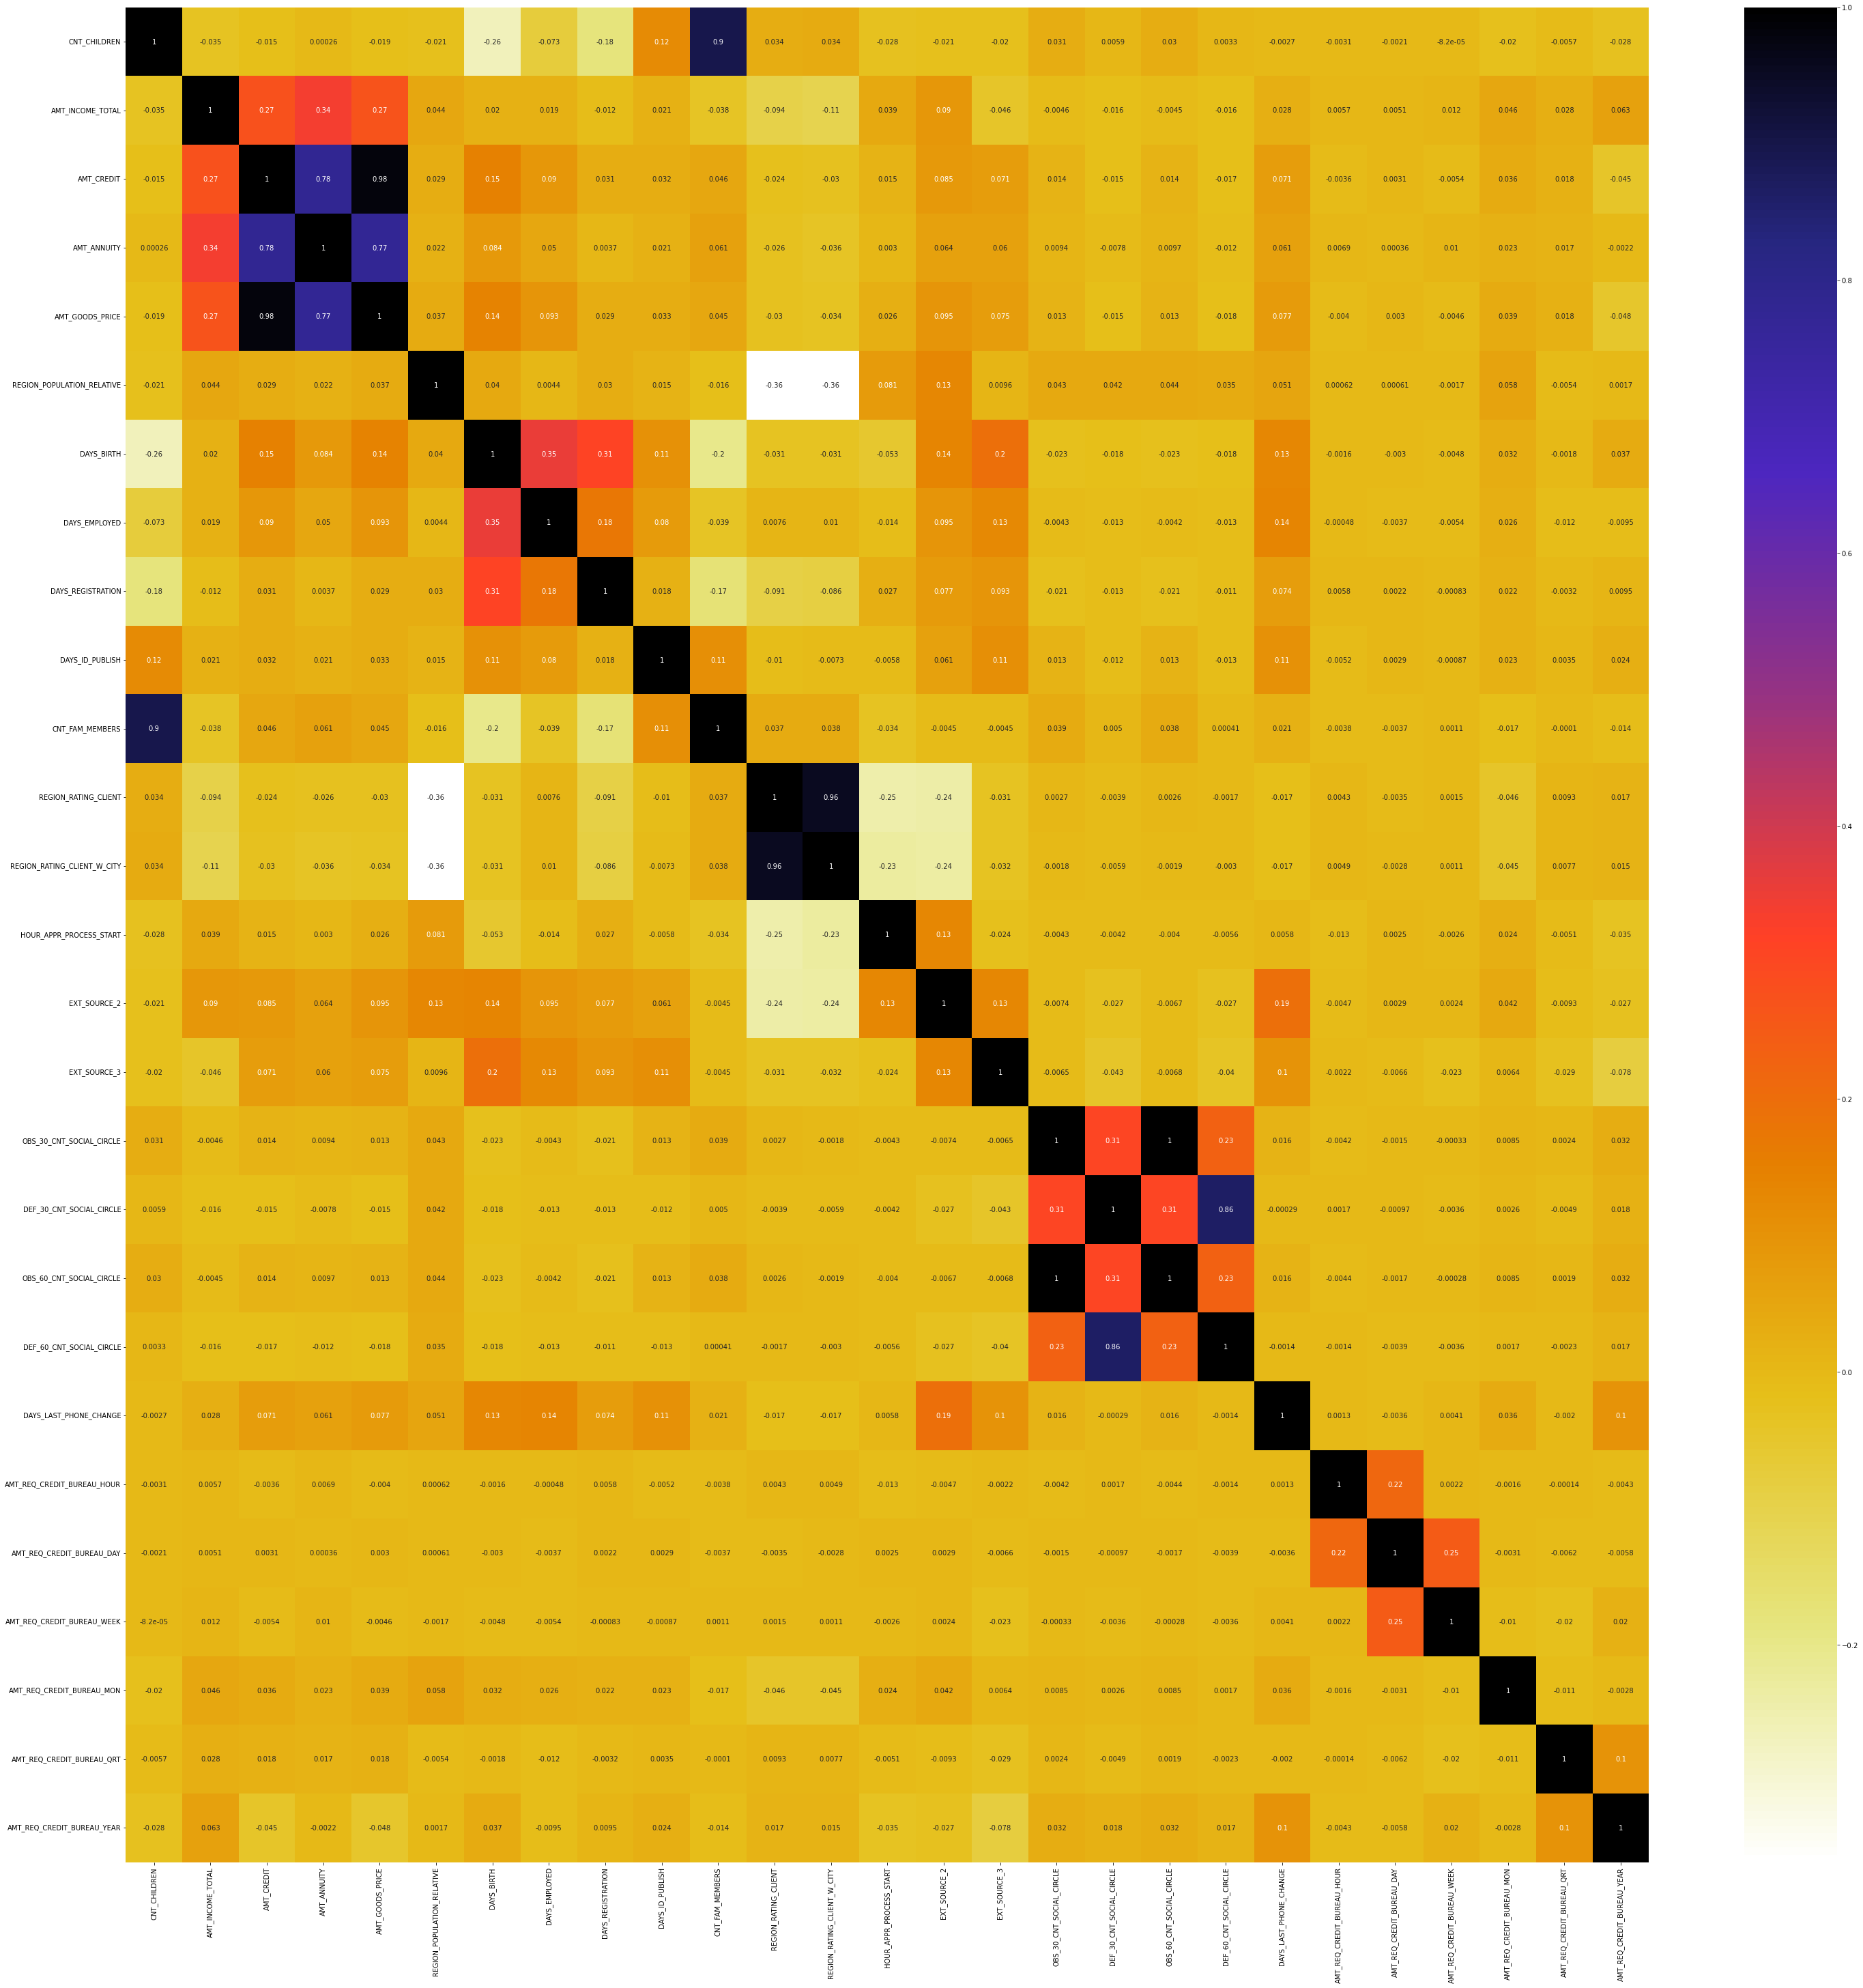

In [37]:
# compute correlation matrix of continous features 
cor = clean_dataset[cont_cols].corr()
#plot heatmap of correlation matrix 
plt.figure(figsize=(50,50))
_ = sns.heatmap(data = cor ,cmap=plt.cm.CMRmap_r, annot= True)

Notice: From the heat map above we can see that some features are highly correlated (dark cells).<br> 
So, we will remove some features to get independent features. Our correlation threshold is 0.85

In [38]:
# get index of correlated features 
corr_idx = get_correlated(cor.to_numpy(), 0.85)
# get index of one feature for each two correlated features 
indicies =np.unique([idx for idx,_ in corr_idx])
# drop one of each two correlated features 
for idx in indicies:
    clean_dataset.drop(cont_cols[idx], axis = 1, inplace=True)
clean_dataset.shape

(113206, 67)

Notice: Removed 5 columns, the features decreased from 72 to 67 features 

## 3.2 Continous Vs Output (Categorical)
remove features that are **NOT** correlated to ouput

In [39]:
# select continuous features 
cont_cols = clean_dataset.columns[(clean_dataset.dtypes == 'int64')|(clean_dataset.dtypes == 'float64')]
cont_cols = [col for col in cont_cols if col not in binary_features]

# select categroical features 
cat_cols = clean_dataset.columns[(clean_dataset.dtypes != 'int64')&(clean_dataset.dtypes != 'float64')].values
cat_cols = np.append(cat_cols, binary_features)

In [40]:
# draw box plot of categorical vs continuous 
def cont_cat_boxplot(cat_col, cont_col):
    plt.figure()
    sns.boxplot(data = clean_dataset, x= cat_col, y = cont_col, order=clean_dataset[cat_col].value_counts().index)
    plt.xticks(rotation = 90)
    plt.show()
    plt.close()

# draw box plot of out (TARGET) vs continuous     
def cont_vs_out(out, cont_col):
    plt.figure()
    sns.boxplot(data = clean_dataset, x= out, y = cont_col, order=out.value_counts().index)
    plt.xticks(rotation = 90)
    plt.show()
    plt.close()

Notice: We will remove features that are not useful for prediction<br> 
From the box plot, if feature axis has same distribution for all categories of categorical<br> 
feature on X axis, then there is no relation between Y axis and X axis, hence, we will remove this feature
because it is a weak regressor. 


AMT_INCOME_TOTAL


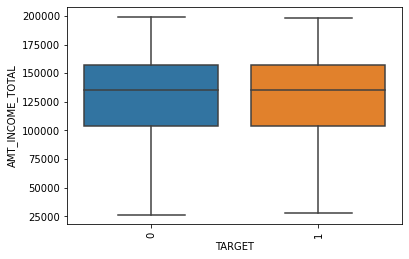

AMT_ANNUITY


AMT_GOODS_PRICE


REGION_POPULATION_RELATIVE


DAYS_BIRTH


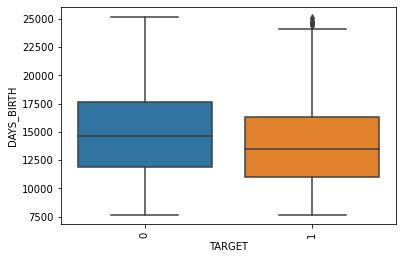

DAYS_EMPLOYED


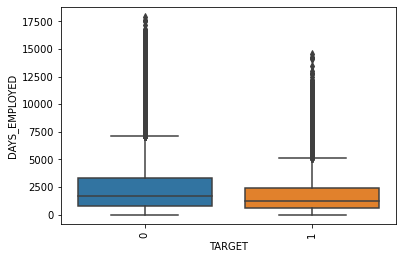

DAYS_REGISTRATION


DAYS_ID_PUBLISH


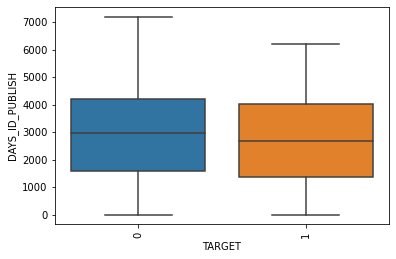

CNT_FAM_MEMBERS


REGION_RATING_CLIENT_W_CITY


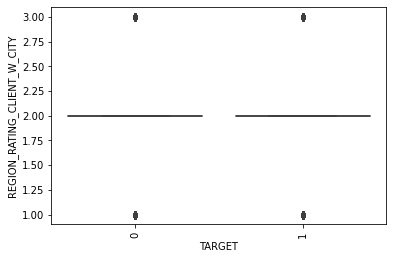

HOUR_APPR_PROCESS_START


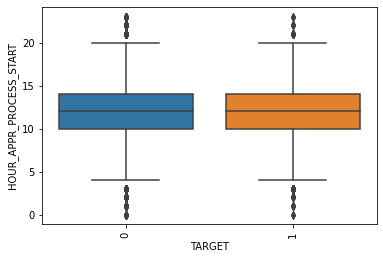

EXT_SOURCE_2


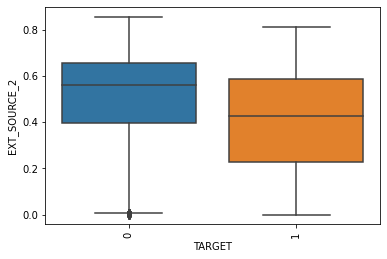

EXT_SOURCE_3


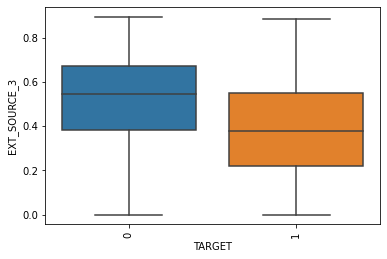

OBS_60_CNT_SOCIAL_CIRCLE


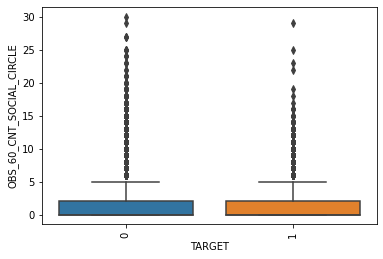

DEF_60_CNT_SOCIAL_CIRCLE


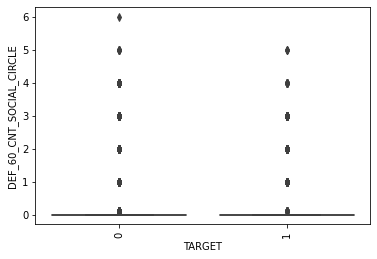

DAYS_LAST_PHONE_CHANGE


AMT_REQ_CREDIT_BUREAU_HOUR


AMT_REQ_CREDIT_BUREAU_DAY


AMT_REQ_CREDIT_BUREAU_WEEK


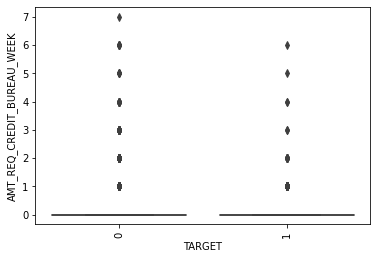

AMT_REQ_CREDIT_BUREAU_MON


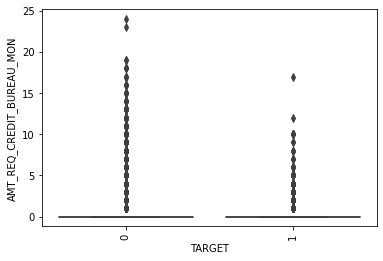

AMT_REQ_CREDIT_BUREAU_QRT


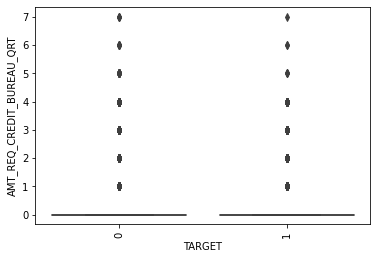

AMT_REQ_CREDIT_BUREAU_YEAR


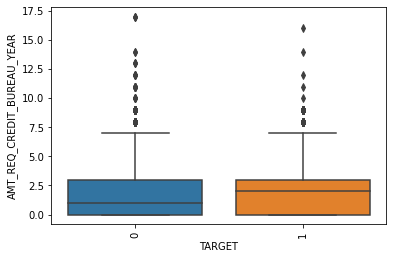

In [41]:
Y = clean_dataset['TARGET']
for j in range(len(cont_cols)):
    print(cont_cols[j])
    cont_vs_out(Y, cont_cols[j])

Notice: After drawing box plot of continuous features vs output TARGET<br> 
We notice that the distribution for many features is almost the same for both output values<br> 
Which indicates that the output doesn't depend on those features. From the above plot we decided to remove the following features as they won't be useful

In [48]:
#useless features (independent of output class)
useless_features = ['AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'CNT_FAM_MEMBERS',
                    'REGION_RATING_CLIENT_W_CITY','HOUR_APPR_PROCESS_START','OBS_60_CNT_SOCIAL_CIRCLE',
                   'DEF_60_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
                   'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT']
# No. of redundant features 
len(useless_features)

12

Notice: Columns; OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, AMT_REQ_CREDIT_BUREAU_QRT, AMT_INCOME_TOTAL, DAYS_EMPLOYED 
Have outliers, we will remove the ouliers and see distribution again

In [88]:
# add features to useless features (independent of output class)
useless_features.extend([])

In [49]:
# drop useless features 
clean_dataset.drop(useless_features, axis = 1, inplace= True)

Notice: They also are independent of output so we will remove them too except DAYS_EMPLOYES, AMT_INCOME_TOTAL there is sort of dependence

In [50]:
# check data shape
clean_dataset.shape

(113206, 55)

Notice Now we have 55 regressors

## 3.3 Binary Categorical Vs binary categorical
For this problem we will use ***PEARSON' R*** method to calculate correlation between <br> binary categorical features<br> 
Remove Features that are correlated

In [52]:
clean_dataset[binary_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113206 entries, 2 to 307510
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   TARGET                       113206 non-null  int64 
 1   NAME_CONTRACT_TYPE           113206 non-null  object
 2   CODE_GENDER                  113206 non-null  object
 3   FLAG_OWN_CAR                 113206 non-null  object
 4   FLAG_OWN_REALTY              113206 non-null  object
 5   FLAG_MOBIL                   113206 non-null  int64 
 6   FLAG_EMP_PHONE               113206 non-null  int64 
 7   FLAG_WORK_PHONE              113206 non-null  int64 
 8   FLAG_CONT_MOBILE             113206 non-null  int64 
 9   FLAG_PHONE                   113206 non-null  int64 
 10  FLAG_EMAIL                   113206 non-null  int64 
 11  REG_REGION_NOT_LIVE_REGION   113206 non-null  int64 
 12  REG_REGION_NOT_WORK_REGION   113206 non-null  int64 
 13  LIVE_REGION_NO

In [53]:
#convert binary categorical type to numerical values
clean_dataset['FLAG_OWN_REALTY'] = pd.get_dummies(clean_dataset['FLAG_OWN_REALTY'], drop_first=True, prefix = 'FLAG_OWN_REALTY', dtype=np.int64)
clean_dataset['FLAG_OWN_CAR'] = pd.get_dummies(clean_dataset['FLAG_OWN_CAR'], drop_first=True, prefix = 'FLAG_OWN_CAR', dtype=np.int64)
clean_dataset['CODE_GENDER'] = pd.get_dummies(clean_dataset['CODE_GENDER'], drop_first=True, prefix = 'CODE_GENDER', dtype=np.int64)
clean_dataset['NAME_CONTRACT_TYPE'] = pd.get_dummies(clean_dataset['NAME_CONTRACT_TYPE'], drop_first=True, prefix = 'NAME_CONTRACT_TYPE', dtype=np.int64)

In [92]:
clean_dataset[binary_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121091 entries, 0 to 307510
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   TARGET                       121091 non-null  int64
 1   NAME_CONTRACT_TYPE           121091 non-null  int64
 2   CODE_GENDER                  121091 non-null  int64
 3   FLAG_OWN_CAR                 121091 non-null  int64
 4   FLAG_OWN_REALTY              121091 non-null  int64
 5   FLAG_MOBIL                   121091 non-null  int64
 6   FLAG_EMP_PHONE               121091 non-null  int64
 7   FLAG_WORK_PHONE              121091 non-null  int64
 8   FLAG_CONT_MOBILE             121091 non-null  int64
 9   FLAG_PHONE                   121091 non-null  int64
 10  FLAG_EMAIL                   121091 non-null  int64
 11  REG_REGION_NOT_LIVE_REGION   121091 non-null  int64
 12  REG_REGION_NOT_WORK_REGION   121091 non-null  int64
 13  LIVE_REGION_NOT_WORK_REGION  

In [54]:
# calculate pearsonr value for binary categorical features 
r_matrix = np.zeros((len(binary_features), len(binary_features)))
for i in range(1, len(binary_features)):
    for j in range(1,len(binary_features)):
        r = stats.pearsonr(clean_dataset[binary_features[i]], clean_dataset[binary_features[j]])
        # check p_value > thr
        if r[1] <= 0.05: # check if correlation is statistically significant
            r_matrix[i, j] = r[0]

/home/khalid/miniconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [55]:
#plot heatmap of pearson'r correlation matrix 
plt.figure(figsize=(50,50))
_ = sns.heatmap(data = r_matrix ,cmap=plt.cm.CMRmap_r, annot= True)

In [95]:
clean_dataset.shape

(121091, 55)

In [56]:
r_matrix.max(), r_matrix.min()

(1.0, -0.6427387919154353)

In [57]:
# get index of correlated features 
corr_idx = get_correlated(r_matrix, 0.85)
# get index of one feature for each two correlated features 
indicies =np.unique([idx for idx,_ in corr_idx])
# drop one of each two correlated features 
for idx in indicies:
    clean_dataset.drop(binary_features[idx], axis = 1, inplace=True)
    binary_features.remove(binary_features[idx])
clean_dataset.shape

(113206, 54)

We can notice that there were 1 binary features that are correlated to another 
features.

## Binary Features Vs Ouput 
Remove Features that are **NOT** correlated to ouput

In [58]:
# calculate pearsonr value for binary categorical features 
warnings.filterwarnings('ignore')
corr_features = np.zeros(len(binary_features))
for i in range(len(binary_features)):
    r = stats.pearsonr(clean_dataset[binary_features[i]], clean_dataset['TARGET'])
    # check if correlation is significant 
    if r[1] <= 0.05: 
        # get correlation value
        corr_features[i] = r[0]    

/home/khalid/miniconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


we will keep features that has significant correlation

In [59]:
binary_to_keep = [f for i,f in enumerate(binary_features) if corr_features[i] > 0.05]

In [60]:
binary_to_keep

['TARGET', 'CODE_GENDER']

Notice: All binary features except CODE_GENDER, doesn't have any correlation with output, so we will drop all of them

In [61]:
features = [f for f in binary_features if f not in binary_to_keep]
clean_dataset.drop(features, axis = 1, inplace=True)
clean_dataset.shape

(113206, 20)

In [62]:
clean_dataset.head()

TARGET  CODE_GENDER  AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
2        0            1       6750.0         135000.0    Unaccompanied   
5        0            1      27517.5         454500.0  Spouse, partner   
6        0            0      41301.0        1395000.0    Unaccompanied   
10       0            0      21177.0         652500.0    Unaccompanied   
12       0            0       5881.5          67500.0    Unaccompanied   

        NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
2                Working  Secondary / secondary special  Single / not married   
5          State servant  Secondary / secondary special               Married   
6   Commercial associate               Higher education               Married   
10               Working               Higher education               Married   
12               Working  Secondary / secondary special               Married   

    NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
2   House / apartment       19046            225             4260.0   
5   House / apartment       16941           1588             4970.0   
6   House / apartment       13778           3130             1213.0   
10  House / apartment       10197            679             4427.0   
12  House / apartment       13439           2717              311.0   

    DAYS_ID_PUBLISH OCCUPATION_TYPE WEEKDAY_APPR_PROCESS_START  \
2              2531        Laborers                     MONDAY   
5               477        Laborers                  WEDNESDAY   
6               619     Accountants                     SUNDAY   
10              738      Core staff                   SATURDAY   
12             3227        Laborers                     FRIDAY   

         ORGANIZATION_TYPE  EXT_SOURCE_2  EXT_SOURCE_3  \
2               Government      0.555912      0.729567   
5                    Other      0.354225      0.621226   
6   Business Entity Type 3      0.724000      0.492060   
10                Medicine      0.651862      0.363945   
12  Business Entity Type 2      0.715042      0.176653   

    DAYS_LAST_PHONE_CHANGE  AMT_REQ_CREDIT_BUREAU_YEAR  
2                    815.0                         0.0  
5                   2536.0                         1.0  
6                   1562.0                         2.0  
10                   844.0                         0.0  
12                  2370.0                         0.0

In [63]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113206 entries, 2 to 307510
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   TARGET                      113206 non-null  int64  
 1   CODE_GENDER                 113206 non-null  int64  
 2   AMT_ANNUITY                 113206 non-null  float64
 3   AMT_GOODS_PRICE             113206 non-null  float64
 4   NAME_TYPE_SUITE             113206 non-null  object 
 5   NAME_INCOME_TYPE            113206 non-null  object 
 6   NAME_EDUCATION_TYPE         113206 non-null  object 
 7   NAME_FAMILY_STATUS          113206 non-null  object 
 8   NAME_HOUSING_TYPE           113206 non-null  object 
 9   DAYS_BIRTH                  113206 non-null  int64  
 10  DAYS_EMPLOYED               113206 non-null  int64  
 11  DAYS_REGISTRATION           113206 non-null  float64
 12  DAYS_ID_PUBLISH             113206 non-null  int64  
 13  OCCUPATION_TYP

## 3.4 Multiple Categorical Vs Continuous
Remove correlated features

In [64]:
# get muliple categorical features 
cat_cols = clean_dataset.columns[(clean_dataset.dtypes == 'object')]
cont_cols = clean_dataset.columns[(clean_dataset.dtypes != 'object')]
cont_cols = [col for col in cont_cols if col not in binary_features]

AMT_ANNUITY vs NAME_TYPE_SUITE


AMT_ANNUITY vs NAME_INCOME_TYPE


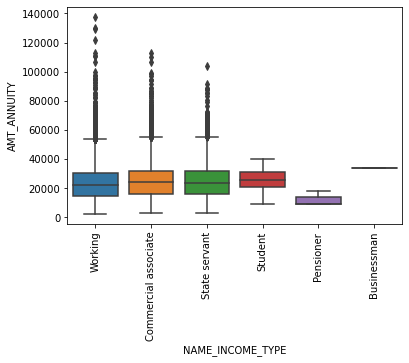

AMT_ANNUITY vs NAME_EDUCATION_TYPE


AMT_ANNUITY vs NAME_FAMILY_STATUS


AMT_ANNUITY vs NAME_HOUSING_TYPE


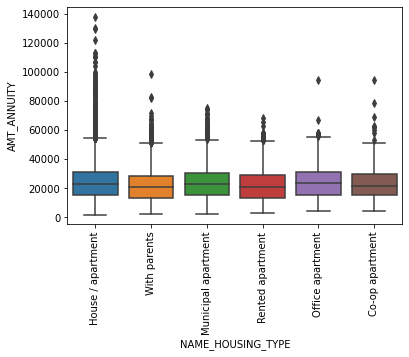

AMT_ANNUITY vs OCCUPATION_TYPE


AMT_ANNUITY vs WEEKDAY_APPR_PROCESS_START


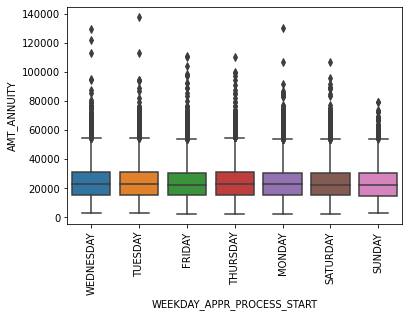

AMT_ANNUITY vs ORGANIZATION_TYPE


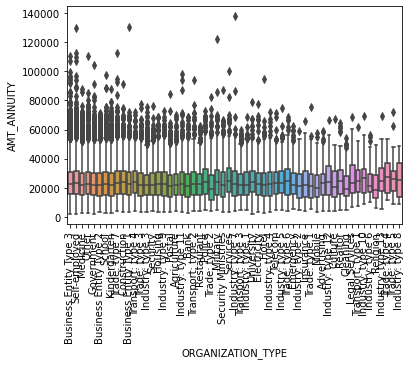

AMT_GOODS_PRICE vs NAME_TYPE_SUITE


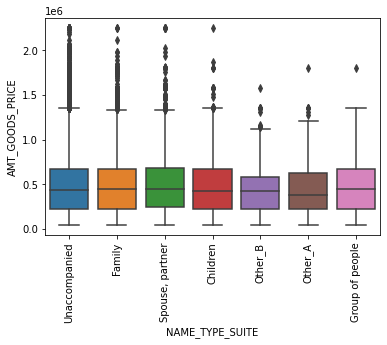

AMT_GOODS_PRICE vs NAME_INCOME_TYPE


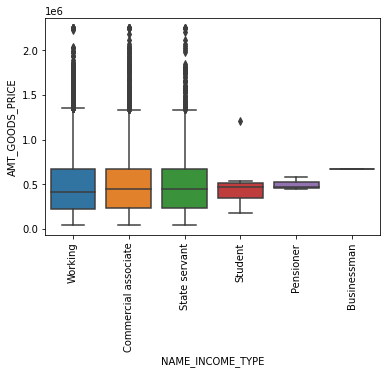

AMT_GOODS_PRICE vs NAME_EDUCATION_TYPE


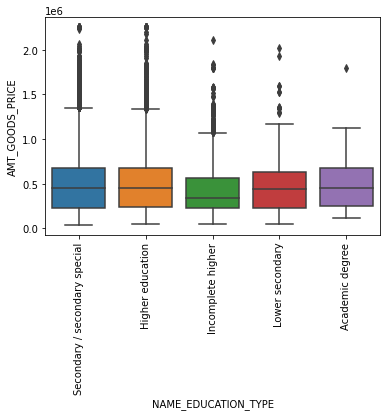

AMT_GOODS_PRICE vs NAME_FAMILY_STATUS


AMT_GOODS_PRICE vs NAME_HOUSING_TYPE


AMT_GOODS_PRICE vs OCCUPATION_TYPE


AMT_GOODS_PRICE vs WEEKDAY_APPR_PROCESS_START


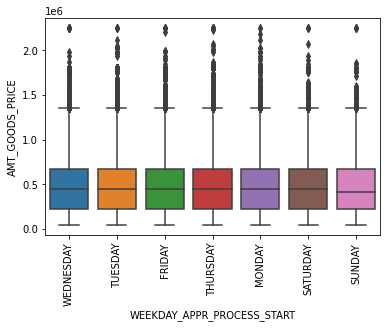

AMT_GOODS_PRICE vs ORGANIZATION_TYPE


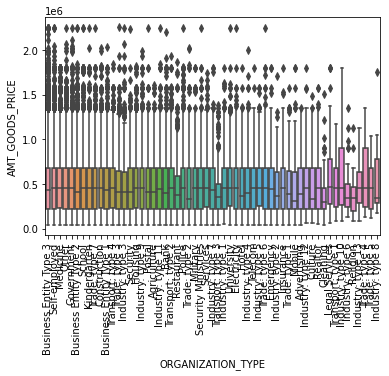

DAYS_BIRTH vs NAME_TYPE_SUITE


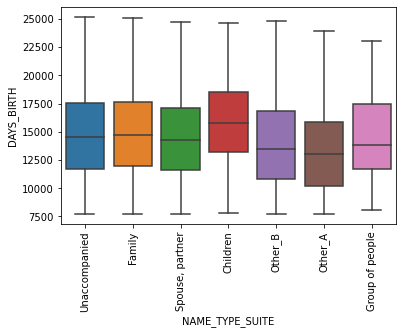

DAYS_BIRTH vs NAME_INCOME_TYPE


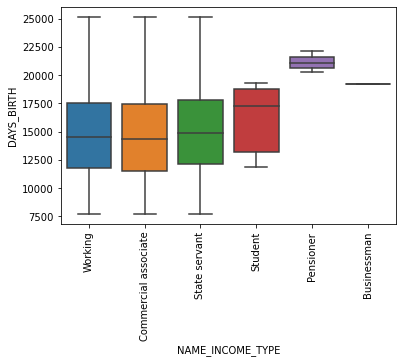

DAYS_BIRTH vs NAME_EDUCATION_TYPE


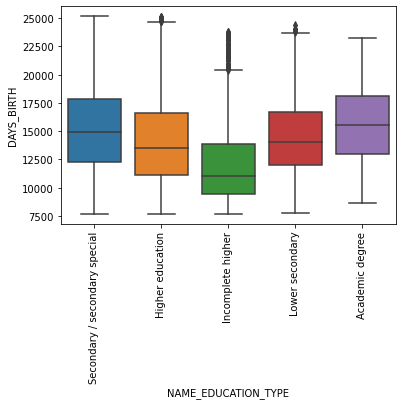

DAYS_BIRTH vs NAME_FAMILY_STATUS


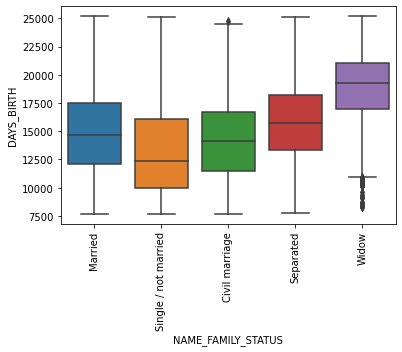

DAYS_BIRTH vs NAME_HOUSING_TYPE


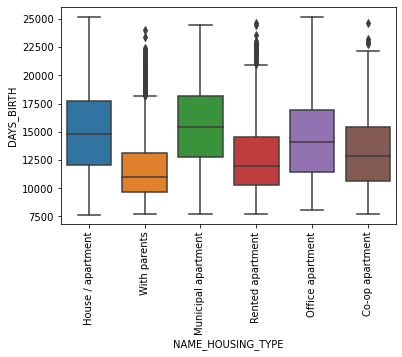

DAYS_BIRTH vs OCCUPATION_TYPE


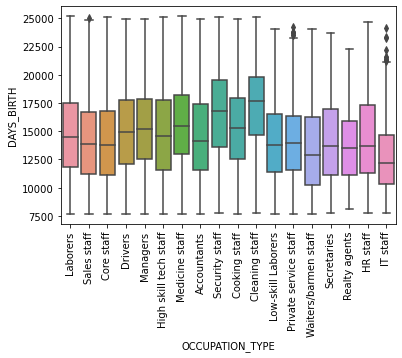

DAYS_BIRTH vs WEEKDAY_APPR_PROCESS_START


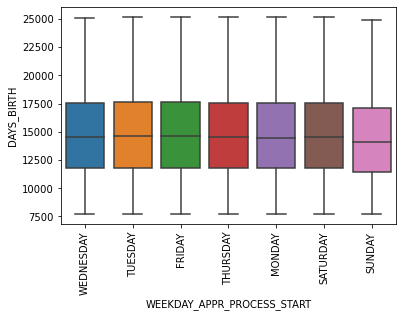

DAYS_BIRTH vs ORGANIZATION_TYPE


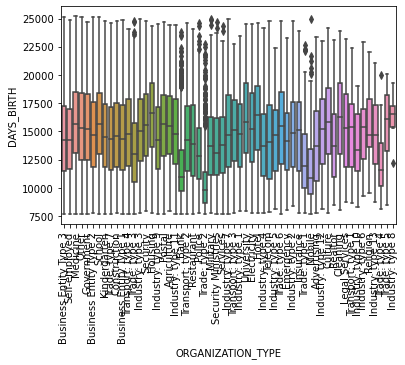

DAYS_EMPLOYED vs NAME_TYPE_SUITE


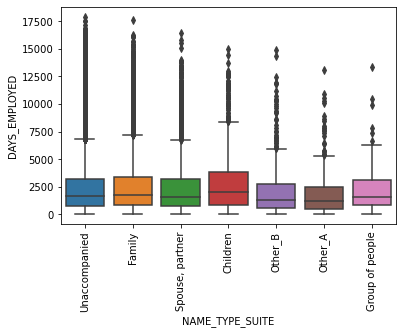

DAYS_EMPLOYED vs NAME_INCOME_TYPE


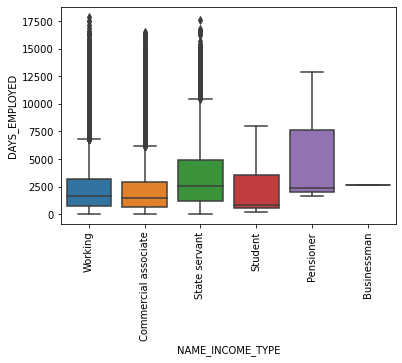

DAYS_EMPLOYED vs NAME_EDUCATION_TYPE


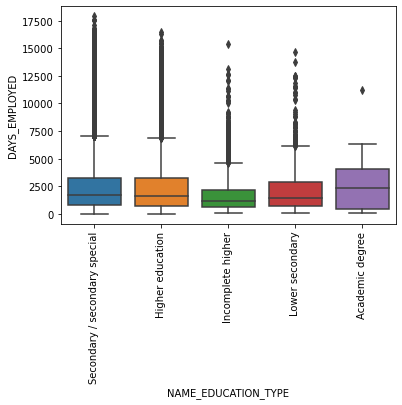

DAYS_EMPLOYED vs NAME_FAMILY_STATUS


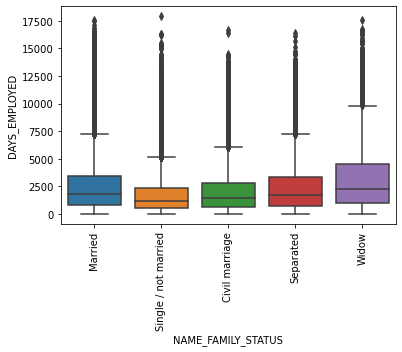

DAYS_EMPLOYED vs NAME_HOUSING_TYPE


DAYS_EMPLOYED vs OCCUPATION_TYPE


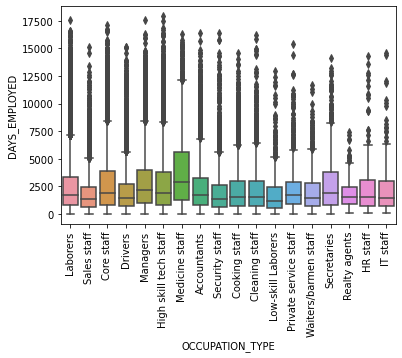

DAYS_EMPLOYED vs WEEKDAY_APPR_PROCESS_START


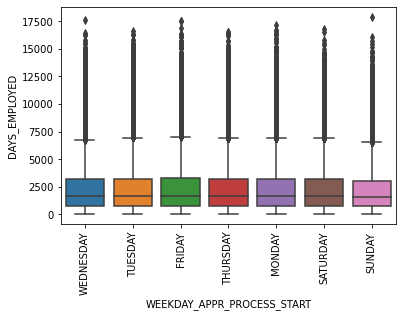

DAYS_EMPLOYED vs ORGANIZATION_TYPE


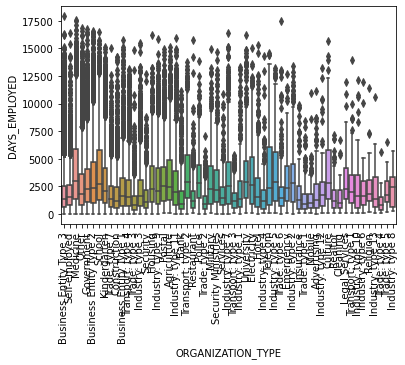

DAYS_REGISTRATION vs NAME_TYPE_SUITE


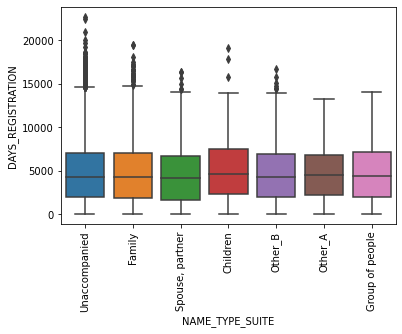

DAYS_REGISTRATION vs NAME_INCOME_TYPE


DAYS_REGISTRATION vs NAME_EDUCATION_TYPE


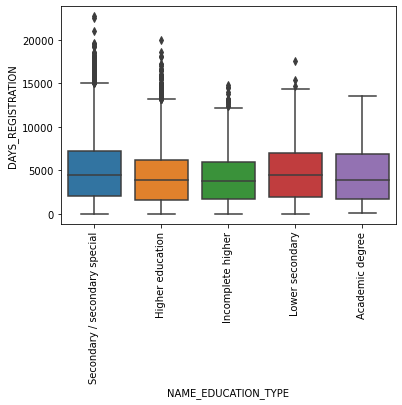

DAYS_REGISTRATION vs NAME_FAMILY_STATUS


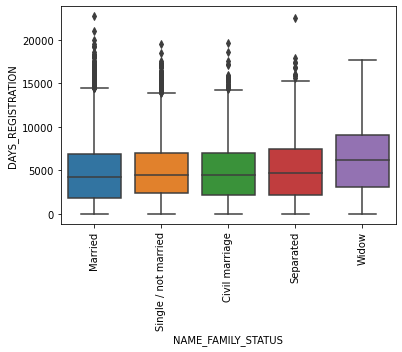

DAYS_REGISTRATION vs NAME_HOUSING_TYPE


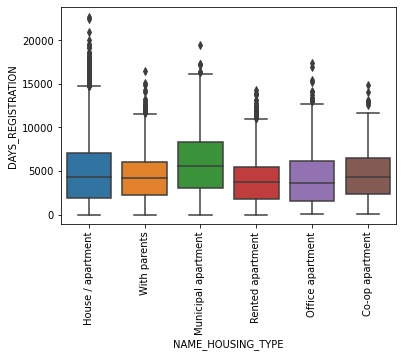

DAYS_REGISTRATION vs OCCUPATION_TYPE


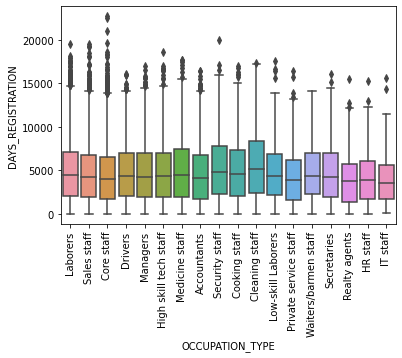

DAYS_REGISTRATION vs WEEKDAY_APPR_PROCESS_START


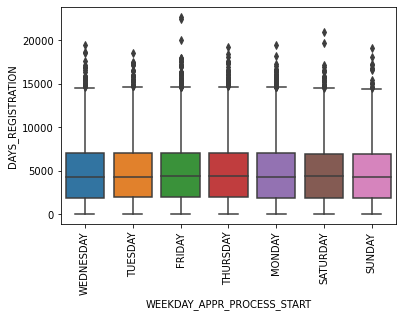

DAYS_REGISTRATION vs ORGANIZATION_TYPE


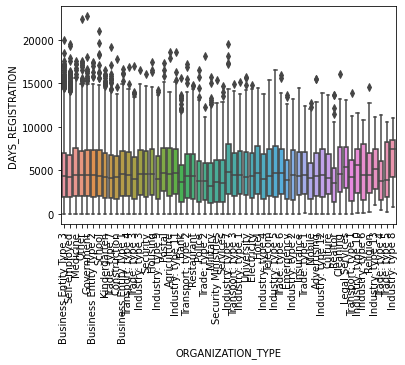

DAYS_ID_PUBLISH vs NAME_TYPE_SUITE


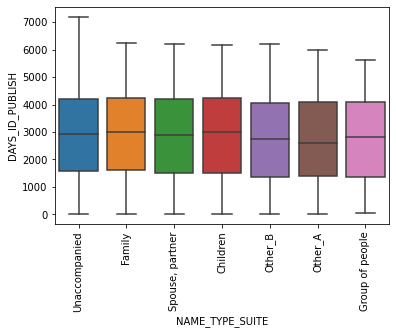

DAYS_ID_PUBLISH vs NAME_INCOME_TYPE


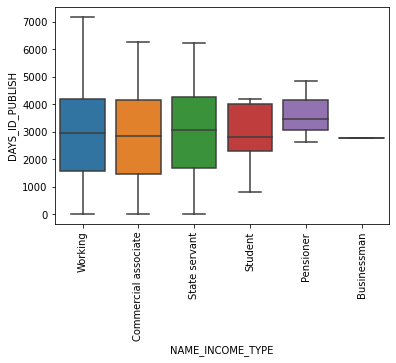

DAYS_ID_PUBLISH vs NAME_EDUCATION_TYPE


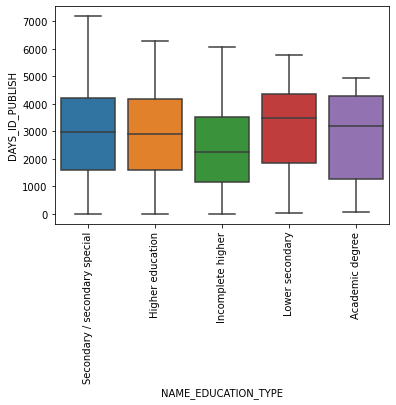

DAYS_ID_PUBLISH vs NAME_FAMILY_STATUS


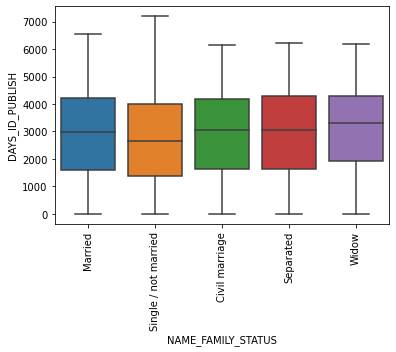

DAYS_ID_PUBLISH vs NAME_HOUSING_TYPE


DAYS_ID_PUBLISH vs OCCUPATION_TYPE


DAYS_ID_PUBLISH vs WEEKDAY_APPR_PROCESS_START


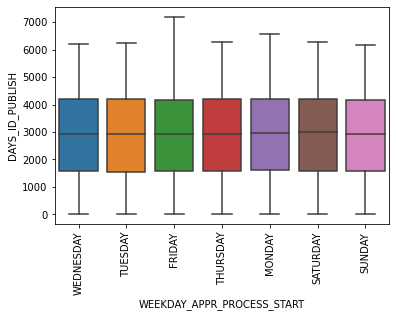

DAYS_ID_PUBLISH vs ORGANIZATION_TYPE


EXT_SOURCE_2 vs NAME_TYPE_SUITE


EXT_SOURCE_2 vs NAME_INCOME_TYPE


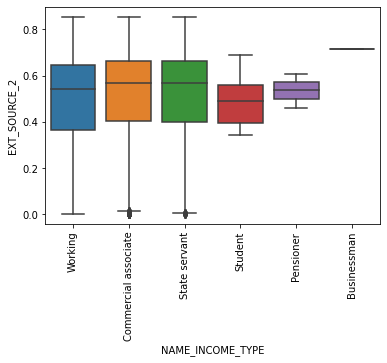

EXT_SOURCE_2 vs NAME_EDUCATION_TYPE


EXT_SOURCE_2 vs NAME_FAMILY_STATUS


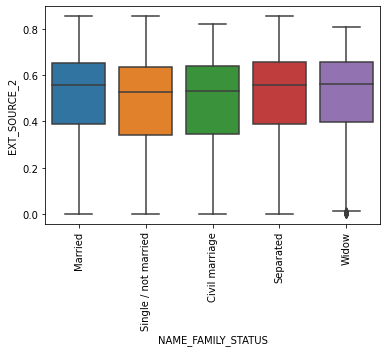

EXT_SOURCE_2 vs NAME_HOUSING_TYPE


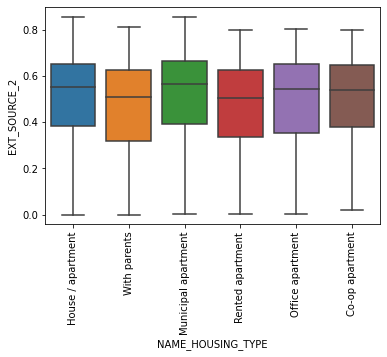

EXT_SOURCE_2 vs OCCUPATION_TYPE


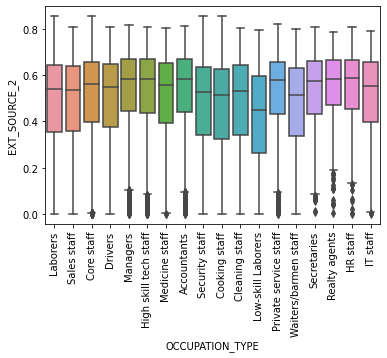

EXT_SOURCE_2 vs WEEKDAY_APPR_PROCESS_START


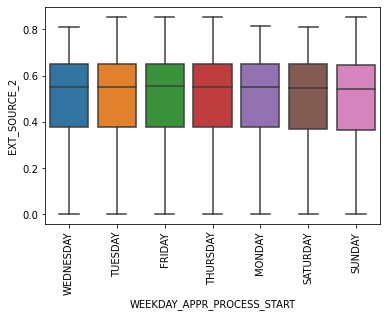

EXT_SOURCE_2 vs ORGANIZATION_TYPE


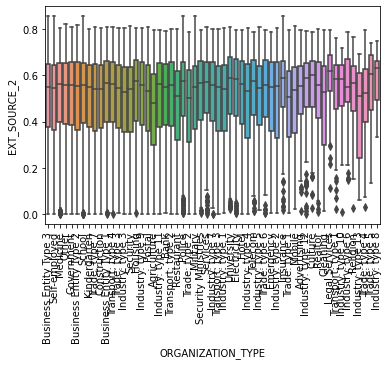

EXT_SOURCE_3 vs NAME_TYPE_SUITE


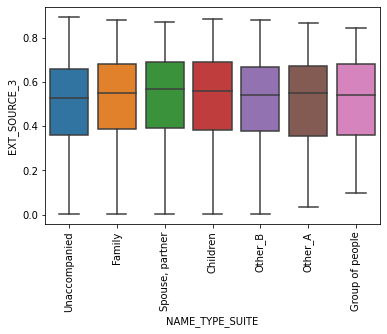

EXT_SOURCE_3 vs NAME_INCOME_TYPE


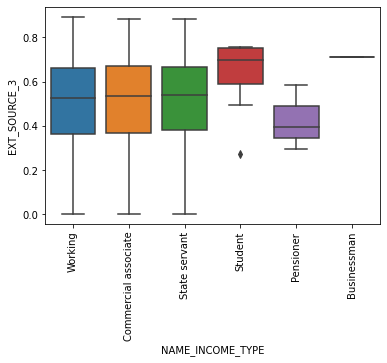

EXT_SOURCE_3 vs NAME_EDUCATION_TYPE


EXT_SOURCE_3 vs NAME_FAMILY_STATUS


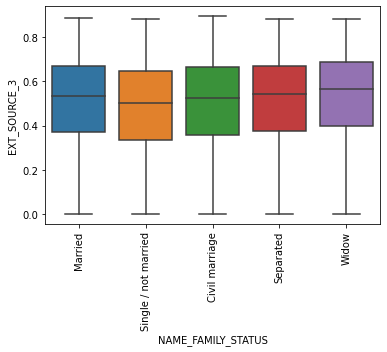

EXT_SOURCE_3 vs NAME_HOUSING_TYPE


EXT_SOURCE_3 vs OCCUPATION_TYPE


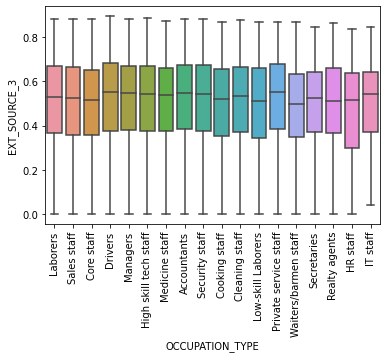

EXT_SOURCE_3 vs WEEKDAY_APPR_PROCESS_START


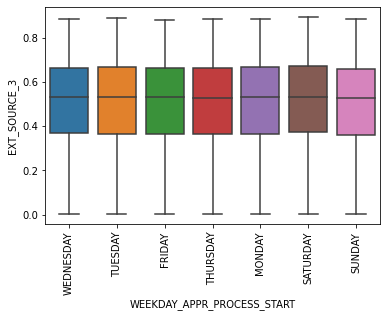

EXT_SOURCE_3 vs ORGANIZATION_TYPE


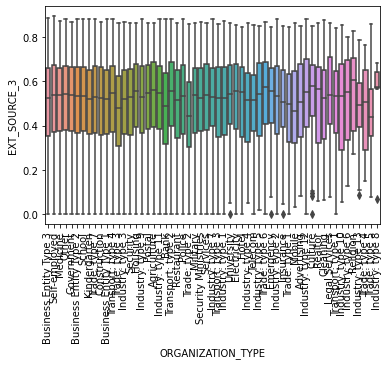

DAYS_LAST_PHONE_CHANGE vs NAME_TYPE_SUITE


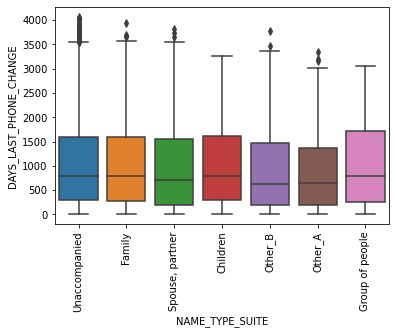

DAYS_LAST_PHONE_CHANGE vs NAME_INCOME_TYPE


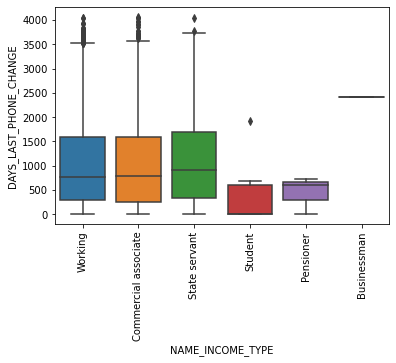

DAYS_LAST_PHONE_CHANGE vs NAME_EDUCATION_TYPE


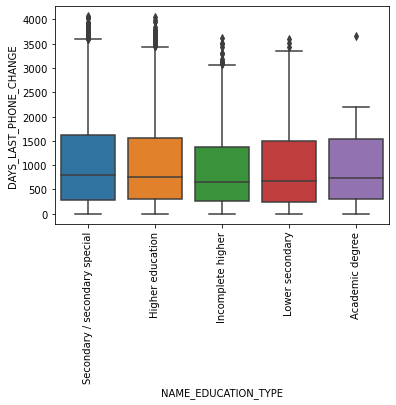

DAYS_LAST_PHONE_CHANGE vs NAME_FAMILY_STATUS


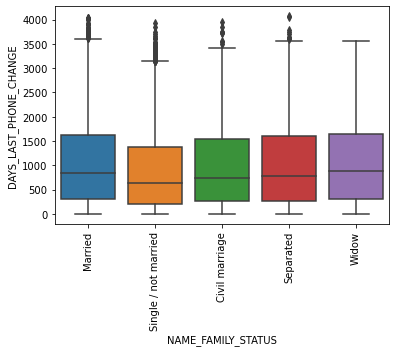

DAYS_LAST_PHONE_CHANGE vs NAME_HOUSING_TYPE


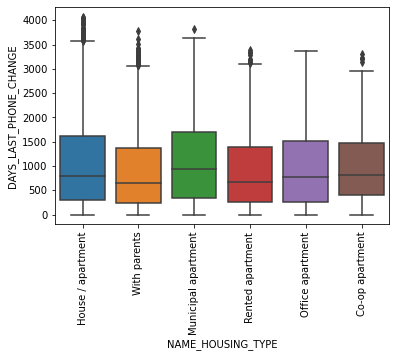

DAYS_LAST_PHONE_CHANGE vs OCCUPATION_TYPE


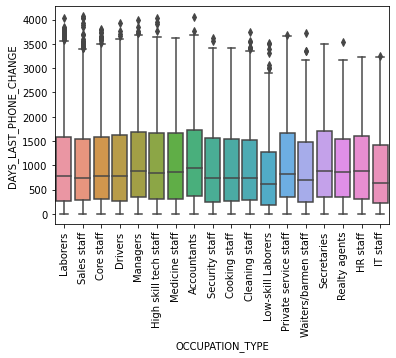

DAYS_LAST_PHONE_CHANGE vs WEEKDAY_APPR_PROCESS_START


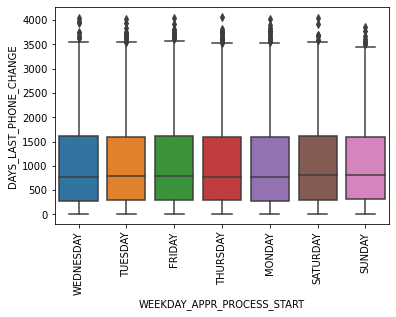

DAYS_LAST_PHONE_CHANGE vs ORGANIZATION_TYPE


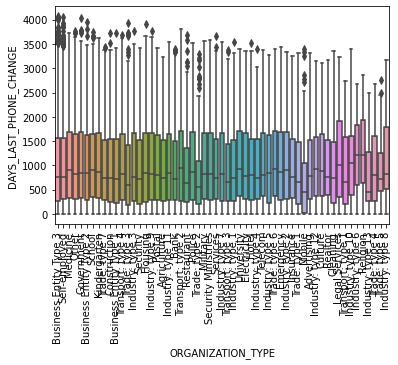

AMT_REQ_CREDIT_BUREAU_YEAR vs NAME_TYPE_SUITE


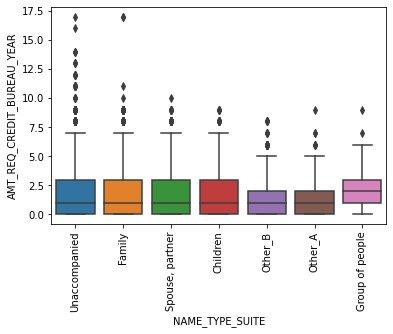

AMT_REQ_CREDIT_BUREAU_YEAR vs NAME_INCOME_TYPE


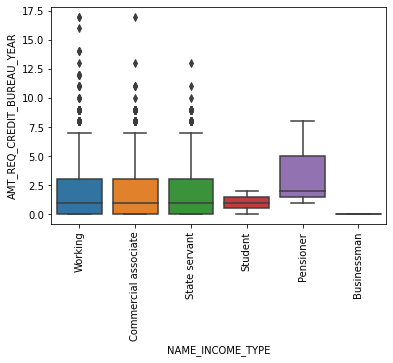

AMT_REQ_CREDIT_BUREAU_YEAR vs NAME_EDUCATION_TYPE


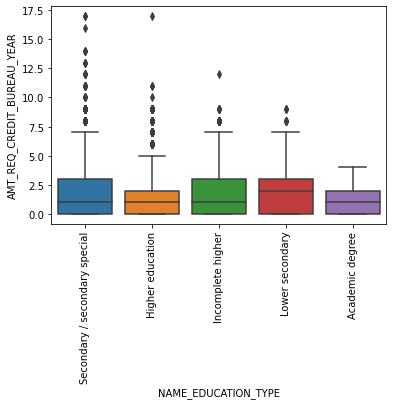

AMT_REQ_CREDIT_BUREAU_YEAR vs NAME_FAMILY_STATUS


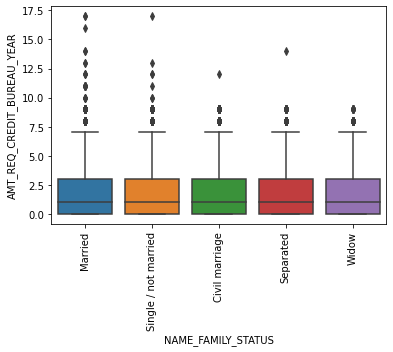

AMT_REQ_CREDIT_BUREAU_YEAR vs NAME_HOUSING_TYPE


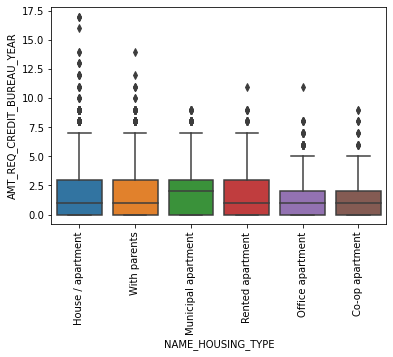

AMT_REQ_CREDIT_BUREAU_YEAR vs OCCUPATION_TYPE


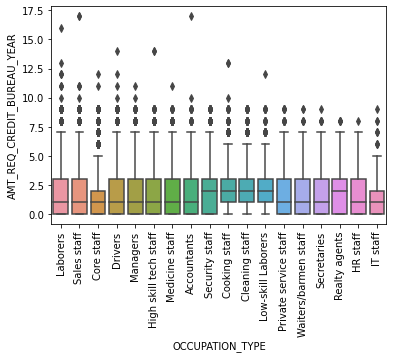

AMT_REQ_CREDIT_BUREAU_YEAR vs WEEKDAY_APPR_PROCESS_START


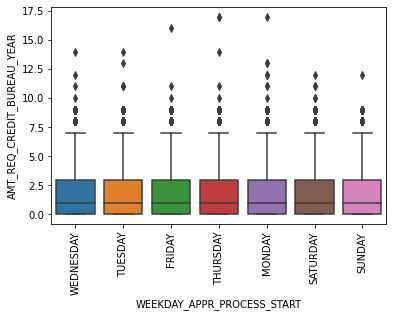

AMT_REQ_CREDIT_BUREAU_YEAR vs ORGANIZATION_TYPE


In [65]:
#plot pox plot of features 
for j in range(len(cont_cols)):
    for i in range(len(cat_cols)):
        print(f'{cont_cols[j]} vs {cat_cols[i]}')
        cont_cat_boxplot(cat_cols[i], cont_cols[j])

Notice: For this analysis we will remove the redundant feature that is highly correlated to another existing one <br>  
We can notice that NO features are significantly correlated

## 3.5 Multiple Categorical Vs Categorical
For this analysis we will use **chi2 Test** to calculate the correlation between the variables

In [66]:
# select multiple categorical Features
cat_cols = clean_dataset.columns[(clean_dataset.dtypes == 'object')]
cat_cols =np.append(cat_cols.values,binary_to_keep)
cat_cols

array(['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'TARGET',
       'CODE_GENDER'], dtype=object)

In [67]:
# convert categorical to numerical values
to_encoded = clean_dataset.copy()
label = preprocessing.LabelEncoder()
encoded_data = pd.DataFrame(to_encoded)
for col in cat_cols:
    encoded_data[col] = label.fit_transform(to_encoded[col])


In [68]:
encoded_data.head()

TARGET  CODE_GENDER  AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
2        0            1       6750.0         135000.0                6   
5        0            1      27517.5         454500.0                5   
6        0            0      41301.0        1395000.0                6   
10       0            0      21177.0         652500.0                6   
12       0            0       5881.5          67500.0                6   

    NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
2                  5                    4                   3   
5                  3                    4                   1   
6                  1                    1                   1   
10                 5                    1                   1   
12                 5                    4                   1   

    NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
2                   1       19046            225             4260.0   
5                   1       16941           1588             4970.0   
6                   1       13778           3130             1213.0   
10                  1       10197            679             4427.0   
12                  1       13439           2717              311.0   

    DAYS_ID_PUBLISH  OCCUPATION_TYPE  WEEKDAY_APPR_PROCESS_START  \
2              2531                8                           1   
5               477                8                           6   
6               619                0                           3   
10              738                3                           2   
12             3227                8                           0   

    ORGANIZATION_TYPE  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_LAST_PHONE_CHANGE  \
2                  11      0.555912      0.729567                   815.0   
5                  33      0.354225      0.621226                  2536.0   
6                   5      0.724000      0.492060                  1562.0   
10                 30      0.651862      0.363945                   844.0   
12                  4      0.715042      0.176653                  2370.0   

    AMT_REQ_CREDIT_BUREAU_YEAR  
2                          0.0  
5                          1.0  
6                          2.0  
10                         0.0  
12                         0.0

In [69]:
# calculate cramer v Value
def calc_cramerV(col1, col2):
    cross_table = pd.crosstab(col1, col2)
    chi2 = chi2_contingency(cross_table)[0]
    n = cross_table.sum().sum()
    phi2 = chi2/n
    r,k = cross_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
#correlation matrix 
rows = []
for i in range(len(cat_cols)):
    cols = []
    for j in range(len(cat_cols)):
        V = calc_cramerV(encoded_data[cat_cols[i]],encoded_data[cat_cols[j]])
        cols.append(V)
    rows.append(cols)

In [70]:
corr_matrix = pd.DataFrame(data = rows, index= cat_cols,columns = cat_cols )

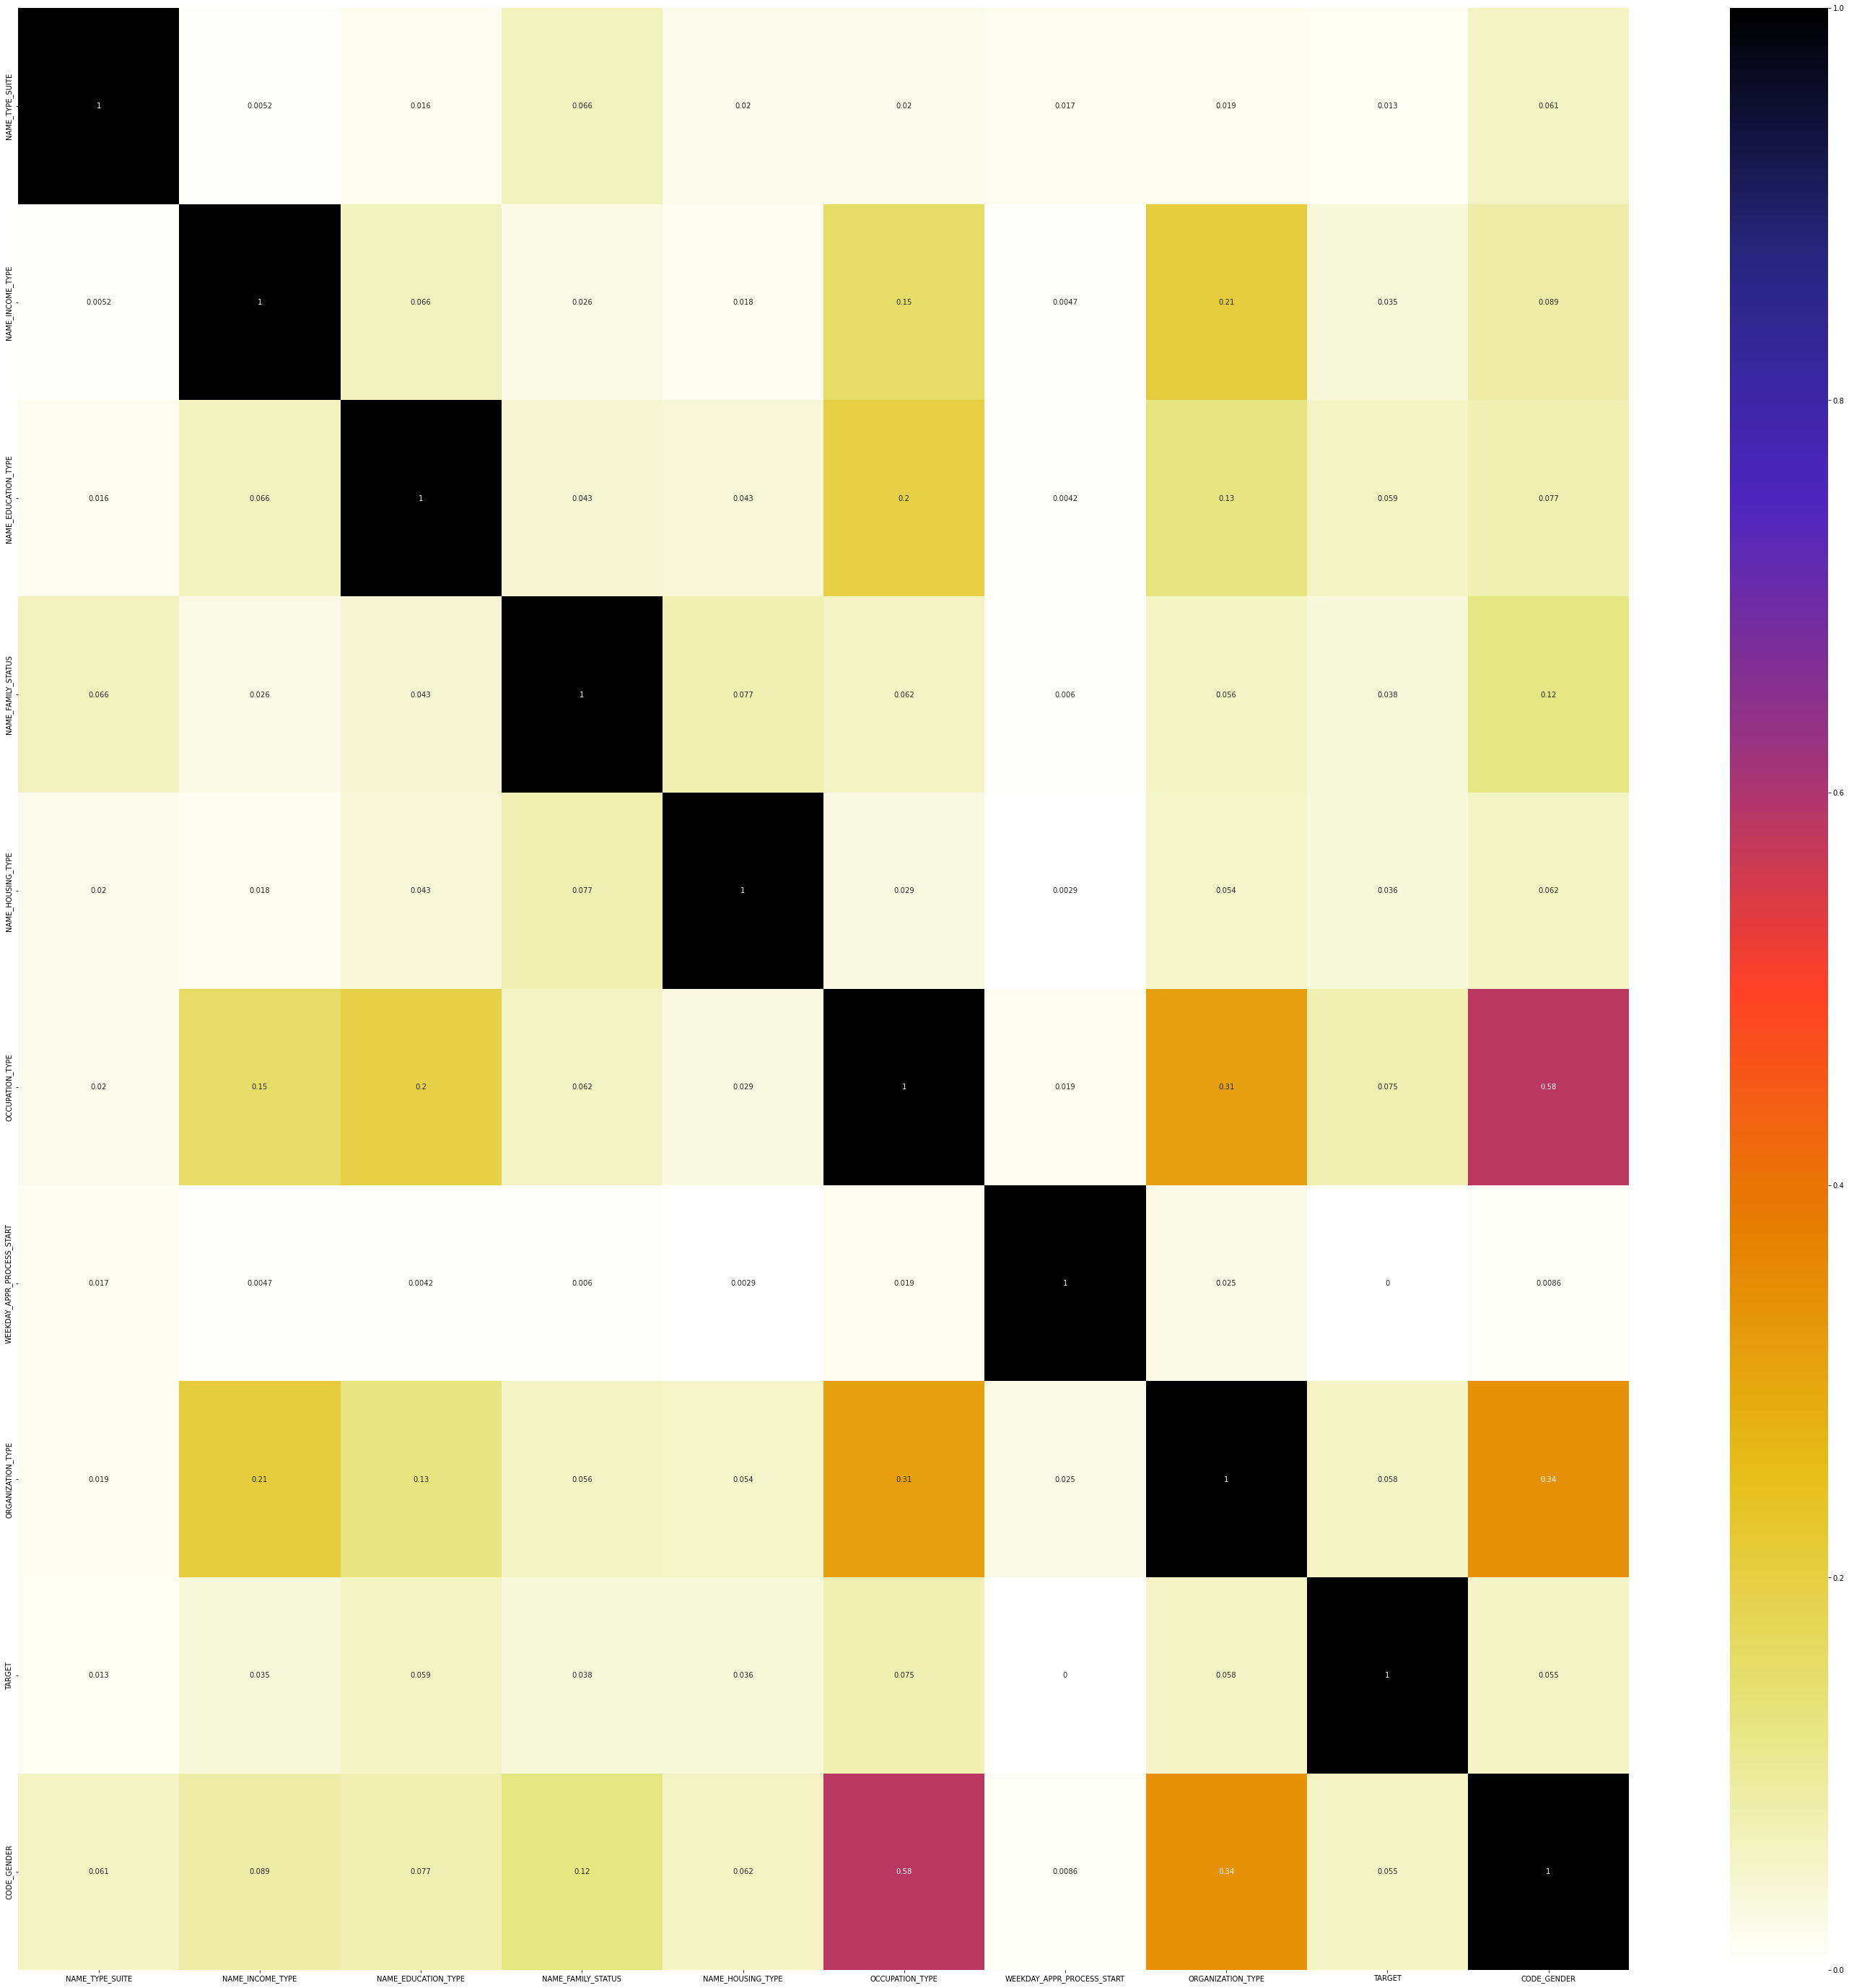

In [71]:
#plot heatmap of pearson'r correlation matrix 
plt.figure(figsize=(50,50))
_ = sns.heatmap(data = corr_matrix ,cmap=plt.cm.CMRmap_r, annot= True)

From Matrix above we can notice that they are weakly correlated to each other. <br> 

In [94]:
corr_matrix

NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
NAME_TYPE_SUITE                    1.000000          0.005229   
NAME_INCOME_TYPE                   0.005229          1.000000   
NAME_EDUCATION_TYPE                0.015831          0.066016   
NAME_FAMILY_STATUS                 0.066160          0.026266   
NAME_HOUSING_TYPE                  0.019888          0.017777   
OCCUPATION_TYPE                    0.020262          0.152629   
WEEKDAY_APPR_PROCESS_START         0.017389          0.004677   
ORGANIZATION_TYPE                  0.019155          0.210319   
TARGET                             0.013406          0.035190   
CODE_GENDER                        0.061080          0.088814   

                            NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
NAME_TYPE_SUITE                        0.015831            0.066160   
NAME_INCOME_TYPE                       0.066016            0.026266   
NAME_EDUCATION_TYPE                    1.000000            0.043473   
NAME_FAMILY_STATUS                     0.043473            1.000000   
NAME_HOUSING_TYPE                      0.042574            0.076821   
OCCUPATION_TYPE                        0.196781            0.061996   
WEEKDAY_APPR_PROCESS_START             0.004223            0.006025   
ORGANIZATION_TYPE                      0.128331            0.055869   
TARGET                                 0.058728            0.038032   
CODE_GENDER                            0.076836            0.123092   

                            NAME_HOUSING_TYPE  OCCUPATION_TYPE  \
NAME_TYPE_SUITE                      0.019888         0.020262   
NAME_INCOME_TYPE                     0.017777         0.152629   
NAME_EDUCATION_TYPE                  0.042574         0.196781   
NAME_FAMILY_STATUS                   0.076821         0.061996   
NAME_HOUSING_TYPE                    1.000000         0.029060   
OCCUPATION_TYPE                      0.029060         1.000000   
WEEKDAY_APPR_PROCESS_START           0.002936         0.019224   
ORGANIZATION_TYPE                    0.054490         0.312593   
TARGET                               0.035800         0.074799   
CODE_GENDER                          0.062268         0.584695   

                            WEEKDAY_APPR_PROCESS_START  ORGANIZATION_TYPE  \
NAME_TYPE_SUITE                               0.017389           0.019155   
NAME_INCOME_TYPE                              0.004677           0.210319   
NAME_EDUCATION_TYPE                           0.004223           0.128331   
NAME_FAMILY_STATUS                            0.006025           0.055869   
NAME_HOUSING_TYPE                             0.002936           0.054490   
OCCUPATION_TYPE                               0.019224           0.312593   
WEEKDAY_APPR_PROCESS_START                    1.000000           0.024790   
ORGANIZATION_TYPE                             0.024790           1.000000   
TARGET                                        0.000000           0.058470   
CODE_GENDER                                   0.008563           0.343330   

                              TARGET  CODE_GENDER  
NAME_TYPE_SUITE             0.013406     0.061080  
NAME_INCOME_TYPE            0.035190     0.088814  
NAME_EDUCATION_TYPE         0.058728     0.076836  
NAME_FAMILY_STATUS          0.038032     0.123092  
NAME_HOUSING_TYPE           0.035800     0.062268  
OCCUPATION_TYPE             0.074799     0.584695  
WEEKDAY_APPR_PROCESS_START  0.000000     0.008563  
ORGANIZATION_TYPE           0.058470     0.343330  
TARGET                      0.999946     0.054743  
CODE_GENDER                 0.054743     0.999980

we can notice that all categorical features are not correlated to TARGET So we will remove features that have less than 5% correlation

In [95]:
clean_dataset.drop(['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE'
                   ,'WEEKDAY_APPR_PROCESS_START'], axis = 1, inplace = True)

In [99]:
f_sel_data = clean_dataset.copy()

# Univariate Analaysis (Understand the Variables) 

In [100]:
f_sel_data.columns

Index(['TARGET', 'CODE_GENDER', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_EDUCATION_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

### Distribution of applications

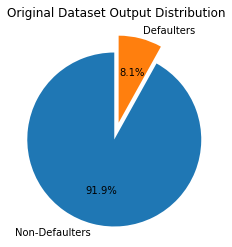

In [101]:
labels = [ 'Non-Defaulters', 'Defaulters']
plt.title("Original Dataset Output Distribution")
_ = plt.pie(org_dataset.TARGET.value_counts(),labels=labels, explode= (0.1,0.1), autopct= "%1.1f%%", startangle=90)

In [102]:
labels = [ 'Non-Defaulters', 'Defaulters']
plt.title("After Cleansing Output Distribution")
_ = plt.pie(f_sel_data.TARGET.value_counts(),labels=labels, explode= (0.1,0.1), autopct= "%1.1f%%", startangle=90)

Insight: that our dataset has 91% Non-Defaulters and 9% Defaulters so our dataset is <b>Impalanced<b>

### Female Vs Male applicants 

In [103]:
# CODE_GENDER => 1 -> Male
#                0 -> Female

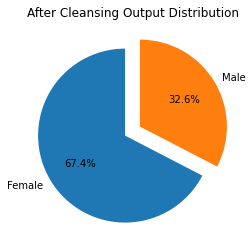

In [104]:
labels = [ 'Female', 'Male']
plt.title("After Cleansing Output Distribution")
_ = plt.pie(f_sel_data.CODE_GENDER.value_counts(),labels=labels, explode= (0.1,0.1), autopct= "%1.1f%%", startangle=90)

Insight: Female Client are so much more than Male Clients 

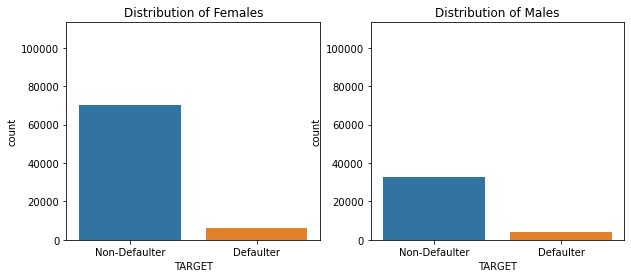

In [105]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(4)
sns.countplot(x = 'TARGET', data= f_sel_data[f_sel_data.CODE_GENDER == 0], ax= ax1)
ax1.set_title('Distribution of Females')
ax1.set_ylim(0, len(f_sel_data))
ax1.set_xticklabels(['Non-Defaulter', 'Defaulter'])

sns.countplot(x = 'TARGET', data= f_sel_data[f_sel_data.CODE_GENDER == 1], ax= ax2)
ax2.set_title('Distribution of Males')
ax2.set_ylim(0, len(f_sel_data))
_ = ax2.set_xticklabels(['Non-Defaulter', 'Defaulter'])

Insight:The number of Non-defalters for men is less than the number of defaulters for women
To get better insight we better calculate percentage

Text(0.5, 1.0, 'Percentage of Females')

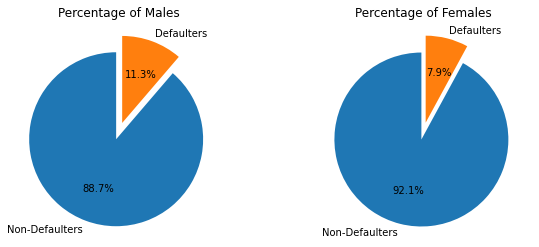

In [106]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(4)
labels = [ 'Non-Defaulters', 'Defaulters']
ax1.pie(f_sel_data[f_sel_data.CODE_GENDER == 1].TARGET.value_counts(),labels=labels, explode= (0.1,0.1), autopct= "%1.1f%%", startangle=90)
ax1.set_title('Percentage of Males')

ax2.pie(f_sel_data[f_sel_data.CODE_GENDER == 0].TARGET.value_counts(),labels=labels, explode= (0.1,0.1), autopct= "%1.1f%%", startangle=90)
ax2.set_title('Percentage of Females')


Insight: Now we can see that the percentage Defaulters of males is larger than females

###  Occupation Type Analysis

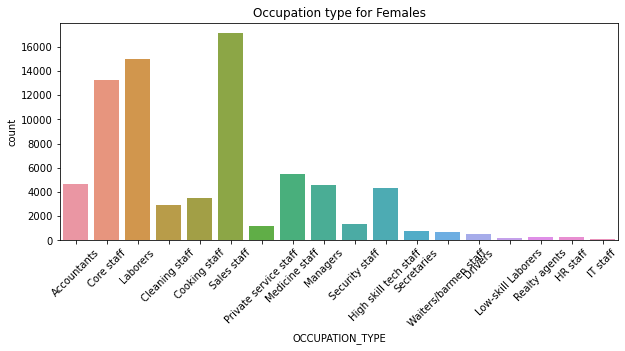

In [107]:
plt.figure(figsize=(10,4))
plt.xticks(rotation = 45)
plt.title("Occupation type for Males")
sns.countplot(x = 'OCCUPATION_TYPE', data= f_sel_data[f_sel_data.CODE_GENDER == 1])
plt.figure(figsize=(10,4))
plt.xticks(rotation = 45)
plt.title("Occupation type for Females")
_ =sns.countplot(x = 'OCCUPATION_TYPE', data= f_sel_data[f_sel_data.CODE_GENDER == 0])

Insight: majority of male clients are laborers followed by drivers

Insight: majority of female clients are Sales staff followed by Laborers, followed by Core staff<br> 

In [109]:
X = f_sel_data.copy()

In [110]:
X.to_csv("selected_dataset.csv", index=False)

# Learning Model

In [24]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import  sklearn.svm as svm
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import warnings
np.random.seed(50)

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

### Encoding Categorial Features

In [26]:
X_df = pd.read_csv("selected_dataset.csv")
X_df.head()

TARGET  CODE_GENDER  AMT_ANNUITY  AMT_GOODS_PRICE  \
0       0            1       6750.0         135000.0   
1       0            1      27517.5         454500.0   
2       0            0      41301.0        1395000.0   
3       0            0      21177.0         652500.0   
4       0            0       5881.5          67500.0   

             NAME_EDUCATION_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0  Secondary / secondary special       19046            225   
1  Secondary / secondary special       16941           1588   
2               Higher education       13778           3130   
3               Higher education       10197            679   
4  Secondary / secondary special       13439           2717   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH OCCUPATION_TYPE       ORGANIZATION_TYPE  \
0             4260.0             2531        Laborers              Government   
1             4970.0              477        Laborers                   Other   
2             1213.0              619     Accountants  Business Entity Type 3   
3             4427.0              738      Core staff                Medicine   
4              311.0             3227        Laborers  Business Entity Type 2   

   EXT_SOURCE_2  EXT_SOURCE_3  DAYS_LAST_PHONE_CHANGE  \
0      0.555912      0.729567                   815.0   
1      0.354225      0.621226                  2536.0   
2      0.724000      0.492060                  1562.0   
3      0.651862      0.363945                   844.0   
4      0.715042      0.176653                  2370.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         0.0  
1                         1.0  
2                         2.0  
3                         0.0  
4                         0.0

In [27]:
def encode_data(X):
    Y = X.TARGET
    X.drop(['TARGET'] , axis = 1, inplace = True)
    cat_columns = ['NAME_EDUCATION_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE']
    dummies = pd.get_dummies(X[cat_columns], drop_first=True)
    X = X.join(dummies)
    X.drop(cat_columns, axis = 1, inplace = True)
    return X, Y



In [28]:
def separate_test(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,stratify = Y)
    return X_train, y_train, X_test, y_test

In [29]:
# Normalize continous data
encoded_X, encoded_Y = encode_data(X_df.copy())
encoded_X /= (abs(encoded_X)).max(axis = 0)

In [30]:
# for col in encoded_X.columns:
#     print(len(encoded_X[col].unique()))
#     if len(encoded_X[col].unique()) == 1:
#         print(col)
#         encoded_X.drop(col, axis= 1, inplace= True)

In [31]:
encoded_X.head()

CODE_GENDER  AMT_ANNUITY  AMT_GOODS_PRICE  DAYS_BIRTH  DAYS_EMPLOYED  \
0          1.0     0.048968         0.059880    0.756034       0.012561   
1          1.0     0.199628         0.201597    0.672475       0.088656   
2          0.0     0.299621         0.618762    0.546920       0.174743   
3          0.0     0.153630         0.289421    0.404771       0.037908   
4          0.0     0.042668         0.029940    0.533463       0.151686   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  EXT_SOURCE_2  EXT_SOURCE_3  \
0           0.187657         0.351674      0.650190      0.816092   
1           0.218933         0.066278      0.414298      0.694903   
2           0.053434         0.086008      0.846784      0.550418   
3           0.195013         0.102543      0.762412      0.407108   
4           0.013700         0.448381      0.836307      0.197603   

   DAYS_LAST_PHONE_CHANGE  ...  ORGANIZATION_TYPE_Trade: type 3  \
0                0.200246  ...                              0.0   
1                0.623096  ...                              0.0   
2                0.383784  ...                              0.0   
3                0.207371  ...                              0.0   
4                0.582310  ...                              0.0   

   ORGANIZATION_TYPE_Trade: type 4  ORGANIZATION_TYPE_Trade: type 5  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   ORGANIZATION_TYPE_Trade: type 6  ORGANIZATION_TYPE_Trade: type 7  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   ORGANIZATION_TYPE_Transport: type 1  ORGANIZATION_TYPE_Transport: type 2  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   ORGANIZATION_TYPE_Transport: type 3  ORGANIZATION_TYPE_Transport: type 4  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   ORGANIZATION_TYPE_University  
0                           0.0  
1                           0.0  
2                           0.0  
3                           0.0  
4                           0.0  

[5 rows x 88 columns]

In [32]:
all_data = encoded_X.join(encoded_Y)
all_data.to_csv('all_data.csv', sep= ',', index= False)

### Helpers 

In [33]:
def svm_clf(X_train, X_valid, y_train, y_valid,kernel , degree, nu = None,c = 1.0, plot = True):
    #fit model
    clf = None 
    if nu == None: 
        clf = svm.SVC(kernel = kernel, gamma='auto',C = c, degree = degree)
    else: 
        clf = svm.Nu_SVC(gamma='auto')
        
    clf.fit(X_train, y_train)
    
    #predict train set
    train_pred = clf.predict(X_train)
    valid_pred = clf.predict(X_valid)
    if plot: 
        print(f'Training Accuracy: {(train_pred == y_train).mean()*100:.2f} , Test Accuracy: {(valid_pred == y_valid).mean()*100:.2f}')
        plot_confusion(y_train, train_pred, y_valid, valid_pred)
    return clf, (train_pred == y_train).mean(),(valid_pred == y_valid).mean()*100, f1_score(y_valid, valid_pred)

def plot_confusion(y_train, train_pred, y_valid, valid_pred):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_figheight(5)
    fig.set_figwidth(8)
    
    ax1.set_title("Training Confuction Matrix")
    ax2.set_title("Testing Confuction Matrix")
    plt.subplots_adjust(left=0.1, bottom=0.1,right=0.9, top=0.9, wspace=0.5, hspace=0.4)
    
    cm = confusion_matrix(y_train, train_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax = ax1)
     
    # predict test set 
   
    cm = confusion_matrix(y_valid, valid_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax = ax2)

def plot_confusion(y_true, y_pred):    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    
def over_sample(X, Y, test_size = 0.2):
    ros = SMOTE(random_state=42,sampling_strategy='minority',)
    return ros.fit_resample(X, Y)
    
    
def under_sample(X,Y, test_size = 0.2): 
    rus = RandomUnderSampler(random_state=42)
    return rus.fit_resample(X,Y)
    

def dt_clf(X_train, X_valid, y_train, y_valid,max_depth = 34, plot = True):
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    valid_pred = dt.predict(X_valid)
    if plot: 
        print(f"Max-Depth is: {dt.tree_.max_depth}")
        print(f"DT: Train Acc: {(train_pred == y_train).mean()*100:.2f} , Test Acc: {(valid_pred == y_valid).mean()*100:.2f}")
        plot_confusion(y_train, train_pred, y_test, test_pred)
    return dt, (train_pred == y_train).mean()*100,(valid_pred == y_valid).mean()*100,f1_score(y_valid, valid_pred)

def knn_clf(X_train, X_valid, y_train, y_valid,k = 5 ,plot = True):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    valid_pred = clf.predict(X_valid)
    if plot:
        print(f'{int(np.sqrt(len(X_train)))}-NN Clf -> Train Accuracy: {(train_pred == y_train).mean()*100:.2f},  Test Accuracy: {(valid_pred == y_valid).mean()*100:.2f}')
        plot_confusion(y_train, train_pred, y_valid, valid_pred)
    return clf, (train_pred == y_train).mean()*100,(valid_pred == y_valid).mean()*100,f1_score(y_valid, valid_pred)

def RF_clf(X_train, X_valid, y_train, y_valid, n_esimators,plot = True):
    rf = RandomForestClassifier(n_estimators= n_esimators)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    valid_pred = rf.predict(X_valid)
    if plot: 
        print(f"DT: Train Acc: {(train_pred == y_train).mean()*100:.2f} , Test Acc: {(valid_pred == y_valid).mean()*100:.2f}")
        plot_confusion(y_train, train_pred, y_valid,  valid_pred)
    return rf, (train_pred == y_train).mean()*100,(valid_pred == y_valid).mean()*100,f1_score(y_valid, valid_pred)


def tune_svm(X_train, X_valid, y_train, y_valid):
    kernel = ['poly', 'rbf', 'sigmoid']
    degree = np.arange(1, 4, 1)
    C = np.arange(1, 100, 20)
    best_model = (None, None, None)
    max_acc = 0
    for kr in kernel:
        if kr == 'poly':
            for deg in degree:
                print(kr,deg)
                for c in C:
                    _, tacc, vacc,f1 = svm_clf(X_train, X_valid, y_train, y_valid, kernel = kr,
                                          degree = deg,c = c, plot = False)
                    if f1 > max_acc:
                        max_acc = f1
                        best_model = (kr, deg, c)
                    if tacc == 100:
                        break
        else:
            print(kr)
            for c in C:
                _, tacc, vacc, f1 = svm_clf(X_train, X_valid, y_train, y_valid, kernel = kr,
                                      degree = deg,c = c, plot = False)
                if f1 > max_acc:
                    max_acc = f1
                    best_model = (kr, deg, c)
                if tacc == 100:
                    break
    return best_model

def tune_knn( X_train, X_valid, y_train, y_valid):
    train_acc = [];  valid_acc = []
    best_k = None
    max_vacc = 0
    for k in np.arange(5, int(np.sqrt(len(X_train))), 10):
        print(f"K: {k}")
        _, tracc, vacc, f1  = knn_clf(X_train, X_valid, y_train, y_valid,k , plot = False)
        # print("done")
        train_acc.extend([tracc])
        valid_acc.extend([vacc])
        if f1 > max_vacc:
            max_vacc = f1
            best_k = k
        if tracc == 100:
            break
            
    plt.figure()
    plt.title("Accuracy Graph vs K value")
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.plot(np.arange(5, int(np.sqrt(len(X_train))), 10), train_acc)
    plt.plot(np.arange(5, int(np.sqrt(len(X_train))), 10), valid_acc)
    return best_k

def tune_DT(X_train, X_valid, y_train, y_valid):
    train_acc = [];  valid_acc = []
    best_depth = None
    max_vacc = 0
    for i in np.arange(3,34,1):
        print(f"depth: {i}")
        _ , tracc, vacc, f1 = dt_clf(X_train, X_valid, y_train, y_valid, max_depth = i, plot= False)
        train_acc.extend([tracc])
        valid_acc.extend([vacc])
        if f1 > max_vacc:
            max_vacc = f1
            best_depth = i
        if tracc == 100:
            break
    plt.figure()
    plt.title("Accuracy Graph vs Max-Depth")
    plt.xlabel("Max-Depth")
    plt.ylabel("Accuracy")
    plt.plot(np.arange(3,len(train_acc)+3,1), train_acc)
    plt.plot(np.arange(3,len(train_acc)+3,1), valid_acc)
    return best_depth

def tune_RF(X_train, X_valid, y_train, y_valid):
    list_train_acc = []
    list_valid_acc = []
    best_valid_acc = 0
    best_n = None
    for n in np.arange(2,100,5):
        print(f"N: {n}")
        _, tacc, vacc, f1 = RF_clf(X_train, X_valid, y_train, y_valid, n_esimators = n, plot= False)
        list_train_acc.extend([tacc])
        list_valid_acc.extend([vacc])
        if tacc == 100:
            break
        if f1  > best_valid_acc:
            best_valid_acc = f1
            best_n = n

    plt.figure()
    plt.title("Accuracy Vs N_Esimators")
    plt.plot(range(len(list_train_acc)),list_train_acc)
    plt.plot(range(len(list_valid_acc)),list_valid_acc)
    return best_n

def tune_LR(X_train, X_valid, y_train, y_valid):
    C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    solvers =['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    epochs = [100,500, 1000, 5000]
    best_model = None
    best_f1 = 0
    for solver in solvers:
        for c in C:
            for epo in epochs:
                print(f'solver= {solver}, c = {c}, epochs = {epo}')
                lReg = LogisticRegression(C= c, max_iter=epo, solver=solver)
                lr_model = lReg.fit(X_train, y_train)
                y_pred = lr_model.predict(X_valid)
                f1 = f1_score(y_valid, y_pred)
                if f1 > best_f1:
                    best_model = (solver, c, epo)
                    best_f1 = f1
    return best_model


def sigmoid(x):
    return 1/(1+np.exp(-x))

def our_accuracy_score(true, predicted):
    return (true == predicted).mean()

class StochasticLReg:
    def __init__(self, lr: int, epochs: int, probability_threshold: float = 0.5, random_state = None):
        self.lr = lr # The learning rate
        self.epochs = epochs # The number of training epochs
        self.probability_threshold = probability_threshold # If the output of the sigmoid function is > probability_threshold, the prediction is considered to be positive (True)
                                                           # otherwise, the prediction is considered to be negative (False)
        self.random_state = random_state # The random state will be used set the random seed for the sake of reproducability

    def _prepare_input(self, X):
        # Here, we add a new input with value 1 to each example. It will be multipled by the bias
        return np.concatenate(([1], X), axis=0)
    
    def _prepare_target(self, y):
        # Here, we convert True to +1 and False to -1
        return np.where(y, 1, -1)

    def _initialize(self, num_weights: int, stdev: float = 0.01):
        # Here, we initialize the weights using a normally distributed random variable with a small standard deviation
        # self.w = np.random.randn(num_weights) * stdev
        self.w = np.zeros(num_weights)

    def _gradient(self, X, y):
        wx = np.dot(X,self.w)
        exp = np.exp(y * wx)
        return - ((y*X) / (1+exp))

    def _update(self, X, y):
        self.w = self.w - self.lr * self._gradient(X,y)

    def fit(self, X, y):
        np.random.seed(self.random_state) # First, we set the seed
        X = self._prepare_input(X.T) # Then we prepare the inputs
        y = self._prepare_target(y) # and prepare the targets too
        self._initialize(X.shape[0]) # and initialize the weights randomly
        for ep in range(self.epochs): # Then we update the weights for a certain number of epochs
            self._update(X, y)
        return self # Return self to match the behavior of Scikit-Learn's LinearRegression fit()
    
    # def predict(self, X):
    #     X = self._prepare_input(X)
    #     return sigmoid(np.dot(X,self.w)) > self.probability_threshold
def prepare_data(data):
#     y = data[:,-1]
#     x = data[:,:-1]
    bias = np.ones((len(data),1))
    return np.concatenate((bias,data ), axis = 1)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def predict(X, w):
    return sigmoid(np.dot(X,w)) > 0.5
   

In [50]:
# extract test data 
X , Y , X_test, y_test = separate_test(encoded_X, encoded_Y)
# extract validation data 
X_imp , Y_imp , X_valid, y_valid = separate_test(X, Y)
# under sample train data 
X_us, Y_us = under_sample(X_imp, Y_imp, test_size=0.1)
# over sample train data 
X_os, Y_os = over_sample(X_imp, Y_imp, test_size=0.1)

## Save Numpy Dataset as CSV

In [51]:
X_us.shape
#     if len(X_os[col].unique()) == 1:
#         print(col)
#         encoded_X.drop(col, axis= 1, inplace= True)

(16542, 88)

In [52]:
# results.mle_retvals

In [53]:
results = sm.Logit(endog=Y_os, exog=X_os).fit(maxiter=500, method='nm')
results.summary()

/home/khalid/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               166850
Model:                          Logit   Df Residuals:                   166762
Method:                           MLE   Df Model:                           87
Date:                Sat, 21 May 2022   Pseudo R-squ.:               8.516e-05
Time:                        02:47:00   Log-Likelihood:            -1.1564e+05
converged:                      False   LL-Null:                   -1.1565e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
CODE_GENDER                                           0.0002      0.013      0.014      0.989      -0.026       0.026
AMT_ANNUITY                                           0.0002      0.103      0.002      0.999      -0.201       0.201
AMT_GOODS_PRICE                                   -1.092e-05      0.064     -0.000      1.000      -0.126       0.126
DAYS_BIRTH                                        -5.383e-05      0.043     -0.001      0.999      -0.084       0.084
DAYS_EMPLOYED                                     -4.996e-05      0.049     -0.001      0.999      -0.095       0.095
DAYS_REGISTRATION                                 -1.122e-05      0.040     -0.000      1.000      -0.078       0.078
DAYS_ID_PUBLISH                                   -1.581e-05      0.025     -0.001      1.000      -0.050       0.050
EXT_SOURCE_2                                         -0.0002      0.022     -0.008      0.994      -0.044       0.044
EXT_SOURCE_3                                         -0.0009      0.023     -0.040      0.968      -0.046       0.044
DAYS_LAST_PHONE_CHANGE                             -7.09e-05      0.028     -0.003      0.998      -0.055       0.055
AMT_REQ_CREDIT_BUREAU_YEAR                         3.889e-05      0.051      0.001      0.999      -0.099       0.099
NAME_EDUCATION_TYPE_Higher education                 -0.0002      0.118     -0.001      0.999      -0.231       0.230
NAME_EDUCATION_TYPE_Incomplete higher              3.899e-05      0.120      0.000      1.000      -0.235       0.235
NAME_EDUCATION_TYPE_Lower secondary                5.464e-05      0.126      0.000      1.000      -0.247       0.247
NAME_EDUCATION_TYPE_Secondary / secondary special     0.0002      0.118      0.002      0.999      -0.230       0.231
OCCUPATION_TYPE_Cleaning staff                       -0.0017      0.041     -0.042      0.967      -0.082       0.079
OCCUPATION_TYPE_Cooking staff                      3.484e-05      0.038      0.001      0.999      -0.075       0.075
OCCUPATION_TYPE_Core staff                        -4.722e-05      0.031     -0.002      0.999      -0.061       0.061
OCCUPATION_TYPE_Drivers                            7.991e-05      0.034      0.002      0.998      -0.067       0.067
OCCUPATION_TYPE_HR staff                           3.613e-05      0.126      0.000      1.000      -0.247       0.247
OCCUPATION_TYPE_High skill tech staff             -1.121e-05      0.035     -0.000      1.000      -0.070       0.069
OCCUPATION_TYPE_IT staff                           2.674e-05      0.129      0.000      1.000      -0.253       0.253
OCCUPATION_TYPE_Laborers                           9.884e-05      0.029      0.003      0.997      -0.057       0.057
OCCUPATION_TYPE_Low-skill Laborers                -8.321e-05      0.050     -0.002      0.999      -0.098       0.098
OCCUPATION_TYPE_Managers                          -9.80

If we train the Logistic regression above we can see the p_value for some regressors is larger than 0.05, which means that theses features are not statistically significant for our prediction, so we will remove them. 

In [54]:
non_significant_cols = ['ORGANIZATION_TYPE_Industry: type 2','ORGANIZATION_TYPE_Trade: type 3','ORGANIZATION_TYPE_Trade: type 3','ORGANIZATION_TYPE_Mobile','OCCUPATION_TYPE_IT staff','OCCUPATION_TYPE_Managers','OCCUPATION_TYPE_Realty agents',
           'ORGANIZATION_TYPE_Agriculture','ORGANIZATION_TYPE_Business Entity Type 1',
          'ORGANIZATION_TYPE_Business Entity Type 2','ORGANIZATION_TYPE_Business Entity Type 3',
          'ORGANIZATION_TYPE_Cleaning','ORGANIZATION_TYPE_Culture','ORGANIZATION_TYPE_Electricity',
          'ORGANIZATION_TYPE_Emergency','ORGANIZATION_TYPE_Government','ORGANIZATION_TYPE_Hotel',
          'ORGANIZATION_TYPE_Housing','ORGANIZATION_TYPE_Industry: type 1','ORGANIZATION_TYPE_Industry: type 10',
          'ORGANIZATION_TYPE_Industry: type 11','ORGANIZATION_TYPE_Industry: type 13','ORGANIZATION_TYPE_Industry: type 3',
          'ORGANIZATION_TYPE_Industry: type 4','ORGANIZATION_TYPE_Industry: type 5','ORGANIZATION_TYPE_Industry: type 6',
          'ORGANIZATION_TYPE_Industry: type 7','ORGANIZATION_TYPE_Industry: type 8','ORGANIZATION_TYPE_Industry: type 9',
          'ORGANIZATION_TYPE_Insurance','ORGANIZATION_TYPE_Kindergarten','ORGANIZATION_TYPE_Legal Services','ORGANIZATION_TYPE_Medicine',
          'ORGANIZATION_TYPE_Other','ORGANIZATION_TYPE_Postal','ORGANIZATION_TYPE_Religion','ORGANIZATION_TYPE_Restaurant',
          'ORGANIZATION_TYPE_School','ORGANIZATION_TYPE_Security','ORGANIZATION_TYPE_Services','ORGANIZATION_TYPE_Telecom',
          'ORGANIZATION_TYPE_Trade: type 1','ORGANIZATION_TYPE_Trade: type 4','ORGANIZATION_TYPE_Trade: type 5',
           'ORGANIZATION_TYPE_Trade: type 6','ORGANIZATION_TYPE_Trade: type 7','ORGANIZATION_TYPE_Transport: type 1',
          'ORGANIZATION_TYPE_Transport: type 2','ORGANIZATION_TYPE_Transport: type 4','ORGANIZATION_TYPE_University',
          'OCCUPATION_TYPE_High skill tech staff','OCCUPATION_TYPE_Private service staff','DAYS_ID_PUBLISH',
          'ORGANIZATION_TYPE_Police','OCCUPATION_TYPE_HR staff','ORGANIZATION_TYPE_Security Ministries',
                        'OCCUPATION_TYPE_Waiters/barmen staff',
          'OCCUPATION_TYPE_Core staff','ORGANIZATION_TYPE_Industry: type 12','OCCUPATION_TYPE_Secretaries','OCCUPATION_TYPE_Medicine staff']
X_os.drop(non_significant_cols, inplace = True, axis = 1)
X_imp.drop(non_significant_cols, inplace = True, axis = 1)
X_us.drop(non_significant_cols, inplace = True, axis = 1)
X_test.drop(non_significant_cols, inplace = True, axis = 1)
X_valid.drop(non_significant_cols, inplace = True, axis = 1)

In [55]:
results = sm.Logit(Y_os, X_os).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.585889
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               166850
Model:                          Logit   Df Residuals:                   166822
Method:                           MLE   Df Model:                           27
Date:                Sat, 21 May 2022   Pseudo R-squ.:                  0.1547
Time:                        02:47:00   Log-Likelihood:                -97756.
converged:                       True   LL-Null:                   -1.1565e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
CODE_GENDER                                           0.1794      0.014     12.495      0.000       0.151       0.208
AMT_ANNUITY                                           3.4042      0.115     29.700      0.000       3.180       3.629
AMT_GOODS_PRICE                                      -1.5477      0.072    -21.383      0.000      -1.690      -1.406
DAYS_BIRTH                                           -0.7491      0.047    -15.878      0.000      -0.842      -0.657
DAYS_EMPLOYED                                        -1.6326      0.056    -29.063      0.000      -1.743      -1.523
DAYS_REGISTRATION                                    -0.4703      0.044    -10.592      0.000      -0.557      -0.383
EXT_SOURCE_2                                         -1.9325      0.025    -76.336      0.000      -1.982      -1.883
EXT_SOURCE_3                                         -2.8852      0.027   -108.804      0.000      -2.937      -2.833
DAYS_LAST_PHONE_CHANGE                               -0.3888      0.031    -12.467      0.000      -0.450      -0.328
AMT_REQ_CREDIT_BUREAU_YEAR                           -0.1413      0.056     -2.506      0.012      -0.252      -0.031
NAME_EDUCATION_TYPE_Higher education                  2.3849      0.033     71.229      0.000       2.319       2.451
NAME_EDUCATION_TYPE_Incomplete higher                 2.4594      0.041     59.462      0.000       2.378       2.540
NAME_EDUCATION_TYPE_Lower secondary                   3.1523      0.060     52.695      0.000       3.035       3.270
NAME_EDUCATION_TYPE_Secondary / secondary special     2.8423      0.033     86.607      0.000       2.778       2.907
OCCUPATION_TYPE_Cleaning staff                        0.2652      0.035      7.504      0.000       0.196       0.334
OCCUPATION_TYPE_Cooking staff                         0.2643      0.031      8.595      0.000       0.204       0.325
OCCUPATION_TYPE_Drivers                               0.2829      0.025     11.523      0.000       0.235       0.331
OCCUPATION_TYPE_Laborers                              0.2791      0.016     17.879      0.000       0.249       0.310
OCCUPATION_TYPE_Low-skill Laborers                    0.5286      0.049     10.791      0.000       0.433       0.625
OCCUPATION_TYPE_Sales staff                           0.1563      0.017      8.962      0.000       0.122       0.191
OCCUPATION_TYPE_Security staff                        0.2075      0.031      6.606      0.000       0.146       0.269
ORGANIZATION_TYPE_Bank                               -0.6011      0.063     -9.521      0.000      -0.725      -0.477
ORGANIZATION_TYPE_Construction                        0.2419      0.034      7.039      0.000       0.175       0.309
ORGANIZATION_TYPE_Military                           -0.4725      0.078     -6.086      0.000      -0.625      -0.320
ORGANIZATION_TYPE_Realtor                             0

Now we can see from the p-values above that all features selected are significant for predicition

According to the coefficients of features we notice the most effective features affect our prediction as follows<br> 
AMT_ANNUITY: for one unit increase the likelihood of prediction is muliplied by exp^3.4042<br> 
EXT_SOURCE_3: for one unit decrease the likelihood of prediction is muliplied by 1/exp^-2.8852<br>
NAME_EDUCATION_TYPE_Higher education: for one unit increase the likelihood of prediction is muliplied by 1/exp^2.3849<br>
NAME_EDUCATION_TYPE_Incomplete higher: if true the likelihood of prediction is muliplied by 1/exp^2.4594<br>
NAME_EDUCATION_TYPE_Lower secondary: if true likelihood of prediction is muliplied by 1/exp^3.1523<br>
NAME_EDUCATION_TYPE_Secondary / secondary special: if true the likelihood of prediction is muliplied by 1/exp^2.8423	<br>

In [56]:
test = X_test.join(y_test)
test.to_csv('test.csv', sep = ',',header = False, index= False)

valid = X_valid.join(y_valid)
valid.to_csv('valid.csv', sep = ',',header = False, index= False)

# imp_data = X_imp.join(Y_imp)
# imp_data.to_csv('imp_data.csv', sep = ',', index= False)


# us_data = X_us.join(Y_us)
# us_data.to_csv('us_data.csv', sep = ',', index= False)

os_data = X_os.join(Y_os)
os_data.to_csv('os_data.csv', sep = ',',header = False, index= False)

### Stochastic Logistic Regression

In [57]:
warnings.filterwarnings('ignore')
best_model = None
best_acc = 0
e = [100, 200,300, 500]
# for epo in e: 
for ep in e: 
    w = None
    print(ep)
    for i in range(len(X_os)):
        our_model = StochasticLReg(lr=0.3, epochs=ep, random_state=0).fit(X_os.iloc[i],Y_os.iloc[i])
        if w is None:
            w = our_model.w
        else:
            w += our_model.w
    X_valid_prep = prepare_data(X_valid)
    acc = (predict(X_valid_prep,w) == y_valid ).mean()
    if  acc > best_acc:
        best_acc= acc
        best_model = (ep)

100
200
300
500


In [58]:
print(best_model, best_acc)

100 0.500637942879576


### Logistic Reg Impalanced

In [59]:
best_model = tune_LR(X_imp, X_valid, Y_imp, y_valid)

solver= newton-cg, c = 0.001, epochs = 100
solver= newton-cg, c = 0.001, epochs = 500
solver= newton-cg, c = 0.001, epochs = 1000
solver= newton-cg, c = 0.001, epochs = 5000
solver= newton-cg, c = 0.01, epochs = 100
solver= newton-cg, c = 0.01, epochs = 500
solver= newton-cg, c = 0.01, epochs = 1000
solver= newton-cg, c = 0.01, epochs = 5000
solver= newton-cg, c = 0.1, epochs = 100
solver= newton-cg, c = 0.1, epochs = 500
solver= newton-cg, c = 0.1, epochs = 1000
solver= newton-cg, c = 0.1, epochs = 5000
solver= newton-cg, c = 1, epochs = 100
solver= newton-cg, c = 1, epochs = 500
solver= newton-cg, c = 1, epochs = 1000
solver= newton-cg, c = 1, epochs = 5000
solver= newton-cg, c = 10, epochs = 100
solver= newton-cg, c = 10, epochs = 500
solver= newton-cg, c = 10, epochs = 1000
solver= newton-cg, c = 10, epochs = 5000
solver= newton-cg, c = 100, epochs = 100
solver= newton-cg, c = 100, epochs = 500
solver= newton-cg, c = 100, epochs = 1000
solver= newton-cg, c = 100, epochs = 5000
solv

In [60]:
best_model

('newton-cg', 100, 100)

In [61]:
lReg = LogisticRegression( solver=best_model[0], C= best_model[1], max_iter=best_model[2])
lr_model = lReg.fit(X_imp, Y_imp)

In [62]:
pred = lr_model.predict(X_test)
plot_confusion(y_test, pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

Test Accuracy:0.9084003179931102
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10300
           1       0.25      0.01      0.02      1021

    accuracy                           0.91     11321
   macro avg       0.58      0.50      0.48     11321
weighted avg       0.85      0.91      0.87     11321



### Logistic Reg UnderSampled

In [63]:
best_model = tune_LR(X_us, X_valid, Y_us, y_valid)

solver= newton-cg, c = 0.001, epochs = 100
solver= newton-cg, c = 0.001, epochs = 500
solver= newton-cg, c = 0.001, epochs = 1000
solver= newton-cg, c = 0.001, epochs = 5000
solver= newton-cg, c = 0.01, epochs = 100
solver= newton-cg, c = 0.01, epochs = 500
solver= newton-cg, c = 0.01, epochs = 1000
solver= newton-cg, c = 0.01, epochs = 5000
solver= newton-cg, c = 0.1, epochs = 100
solver= newton-cg, c = 0.1, epochs = 500
solver= newton-cg, c = 0.1, epochs = 1000
solver= newton-cg, c = 0.1, epochs = 5000
solver= newton-cg, c = 1, epochs = 100
solver= newton-cg, c = 1, epochs = 500
solver= newton-cg, c = 1, epochs = 1000
solver= newton-cg, c = 1, epochs = 5000
solver= newton-cg, c = 10, epochs = 100
solver= newton-cg, c = 10, epochs = 500
solver= newton-cg, c = 10, epochs = 1000
solver= newton-cg, c = 10, epochs = 5000
solver= newton-cg, c = 100, epochs = 100
solver= newton-cg, c = 100, epochs = 500
solver= newton-cg, c = 100, epochs = 1000
solver= newton-cg, c = 100, epochs = 5000
solv

In [64]:
best_model

('liblinear', 0.1, 100)

In [65]:
lReg = LogisticRegression( solver=best_model[0], C= best_model[1], max_iter=best_model[2])
lr_model = lReg.fit(X_us, Y_us)

Test Accuracy:0.6783853016517976
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     10300
           1       0.17      0.67      0.27      1021

    accuracy                           0.68     11321
   macro avg       0.56      0.68      0.53     11321
weighted avg       0.88      0.68      0.75     11321



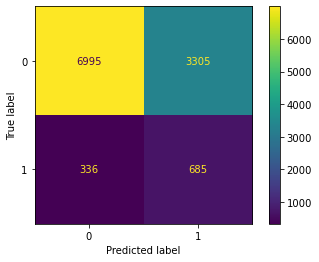

In [66]:
pred = lr_model.predict(X_test)
plot_confusion(y_test, pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### Logistic Reg OverSampled

In [67]:
best_model = tune_LR(X_os, X_valid, Y_os, y_valid)

solver= newton-cg, c = 0.001, epochs = 100
solver= newton-cg, c = 0.001, epochs = 500
solver= newton-cg, c = 0.001, epochs = 1000
solver= newton-cg, c = 0.001, epochs = 5000
solver= newton-cg, c = 0.01, epochs = 100
solver= newton-cg, c = 0.01, epochs = 500
solver= newton-cg, c = 0.01, epochs = 1000
solver= newton-cg, c = 0.01, epochs = 5000
solver= newton-cg, c = 0.1, epochs = 100
solver= newton-cg, c = 0.1, epochs = 500
solver= newton-cg, c = 0.1, epochs = 1000
solver= newton-cg, c = 0.1, epochs = 5000
solver= newton-cg, c = 1, epochs = 100
solver= newton-cg, c = 1, epochs = 500
solver= newton-cg, c = 1, epochs = 1000
solver= newton-cg, c = 1, epochs = 5000
solver= newton-cg, c = 10, epochs = 100
solver= newton-cg, c = 10, epochs = 500
solver= newton-cg, c = 10, epochs = 1000
solver= newton-cg, c = 10, epochs = 5000
solver= newton-cg, c = 100, epochs = 100
solver= newton-cg, c = 100, epochs = 500
solver= newton-cg, c = 100, epochs = 1000
solver= newton-cg, c = 100, epochs = 5000
solv

In [68]:
lReg = LogisticRegression( solver=best_model[0], C= best_model[1], max_iter=best_model[2])
lr_model = lReg.fit(X_os, Y_os)

In [69]:
pred = lr_model.predict(X_test)
plot_confusion(y_test, pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

Test Accuracy:0.6835085239819804
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     10300
           1       0.17      0.67      0.28      1021

    accuracy                           0.68     11321
   macro avg       0.56      0.68      0.54     11321
weighted avg       0.88      0.68      0.75     11321



### Navie Bayes UnderSampled

### Navie Bayes Impalanced

Test Accuracy:0.8597297058563731
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     10300
           1       0.18      0.16      0.17      1021

    accuracy                           0.86     11321
   macro avg       0.55      0.54      0.55     11321
weighted avg       0.85      0.86      0.86     11321



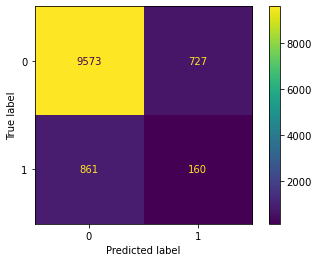

In [70]:
gnb = GaussianNB()
gnb_model = gnb.fit(X_imp,Y_imp)
pred = gnb_model.predict(X_test)
plot_confusion(y_test, pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

Test Accuracy:0.6704354738980656
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     10300
           1       0.16      0.60      0.25      1021

    accuracy                           0.67     11321
   macro avg       0.55      0.64      0.52     11321
weighted avg       0.87      0.67      0.74     11321



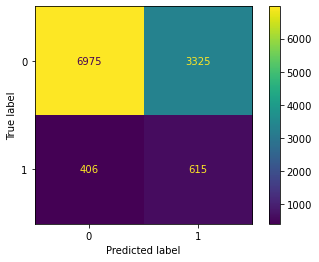

In [71]:
gnb = GaussianNB()
gnb_model = gnb.fit(X_us,Y_us)
pred = gnb_model.predict(X_test)
plot_confusion(y_test, pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### Navie Bayes OverSampled

Test Accuracy:0.6510025616111651
              precision    recall  f1-score   support

           0       0.94      0.66      0.77     10300
           1       0.15      0.60      0.24      1021

    accuracy                           0.65     11321
   macro avg       0.55      0.63      0.51     11321
weighted avg       0.87      0.65      0.73     11321



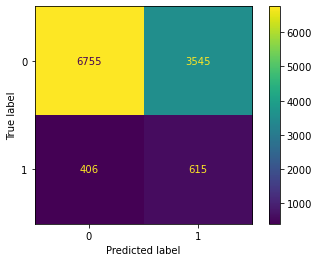

In [72]:
gnb = GaussianNB()
gnb_model = gnb.fit(X_os,Y_os)
pred = gnb_model.predict(X_test)
plot_confusion(y_test, pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### DT UnderSample

depth: 3
depth: 4
depth: 5
depth: 6
depth: 7
depth: 8
depth: 9
depth: 10
depth: 11
depth: 12
depth: 13
depth: 14
depth: 15
depth: 16
depth: 17
depth: 18
depth: 19
depth: 20
depth: 21
depth: 22
depth: 23
depth: 24
depth: 25
depth: 26
depth: 27
depth: 28
depth: 29
depth: 30


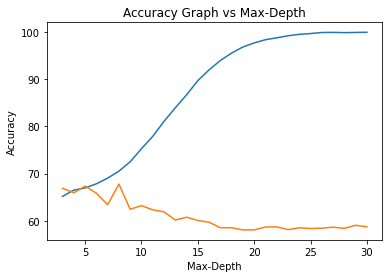

In [73]:
best_depth = tune_DT(X_us, X_valid, Y_us, y_valid)

In [74]:
dt_model ,_,_, _ = dt_clf(X_us, X_valid, Y_us, y_valid, max_depth = best_depth, plot= False)

Test Accuracy:0.6704354738980656
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     10300
           1       0.16      0.63      0.26      1021

    accuracy                           0.67     11321
   macro avg       0.55      0.65      0.52     11321
weighted avg       0.88      0.67      0.74     11321



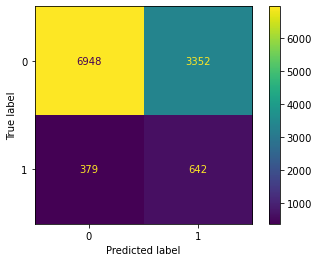

In [75]:
pred = dt_model.predict(X_test)
plot_confusion(y_test, pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### DT Impalanced

depth: 3
depth: 4
depth: 5
depth: 6
depth: 7
depth: 8
depth: 9
depth: 10
depth: 11
depth: 12
depth: 13
depth: 14
depth: 15
depth: 16
depth: 17
depth: 18
depth: 19
depth: 20
depth: 21
depth: 22
depth: 23
depth: 24
depth: 25
depth: 26
depth: 27
depth: 28
depth: 29
depth: 30
depth: 31
depth: 32
depth: 33


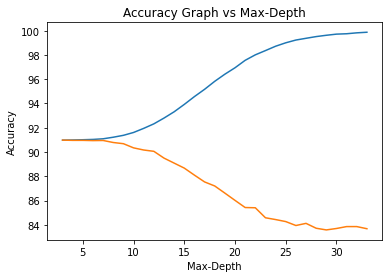

In [76]:
best_depth = tune_DT(X_imp, X_valid, Y_imp, y_valid)

In [77]:
dt_model ,_,_ , _ = dt_clf(X_imp, X_valid, Y_imp , y_valid, max_depth = best_depth, plot= False)

Test Accuracy:0.8364985425315785
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     10300
           1       0.14      0.17      0.15      1021

    accuracy                           0.84     11321
   macro avg       0.53      0.53      0.53     11321
weighted avg       0.85      0.84      0.84     11321



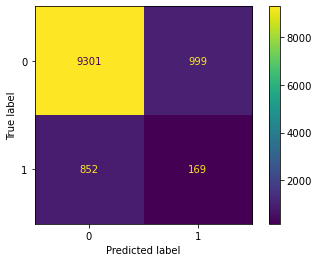

In [78]:
pred = dt_model.predict(X_test)
plot_confusion(y_test, pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### DT OverSample

depth: 3
depth: 4
depth: 5
depth: 6
depth: 7
depth: 8
depth: 9
depth: 10
depth: 11
depth: 12
depth: 13
depth: 14
depth: 15
depth: 16
depth: 17
depth: 18
depth: 19
depth: 20
depth: 21
depth: 22
depth: 23
depth: 24
depth: 25
depth: 26
depth: 27
depth: 28
depth: 29
depth: 30
depth: 31
depth: 32
depth: 33


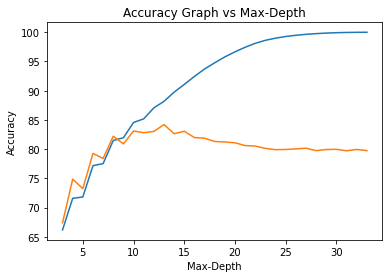

In [79]:
best_depth = tune_DT(X_os, X_valid, Y_os, y_valid)

In [80]:
dt_model ,_,_,_ = dt_clf(X_os, X_valid, Y_os, y_valid, max_depth = best_depth, plot= False)

Test Accuracy:0.7314724847628301
              precision    recall  f1-score   support

           0       0.94      0.76      0.84     10300
           1       0.16      0.49      0.25      1021

    accuracy                           0.73     11321
   macro avg       0.55      0.62      0.54     11321
weighted avg       0.87      0.73      0.78     11321



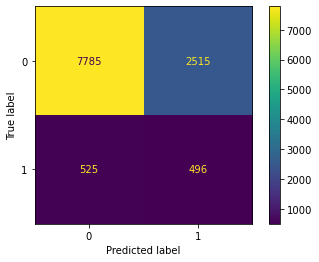

In [81]:
pred = dt_model.predict(X_test)
plot_confusion(y_test,pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### KNN UnderSampled

K: 5
K: 15
K: 25
K: 35
K: 45
K: 55
K: 65
K: 75
K: 85
K: 95
K: 105
K: 115
K: 125


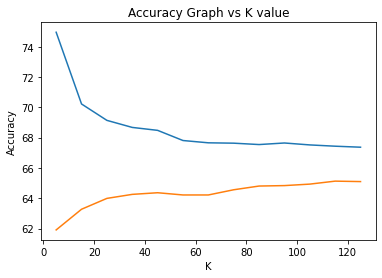

In [82]:
best_k = tune_knn(X_us, X_valid, Y_us, y_valid)

In [83]:
knn_model, _, _ ,_ = knn_clf(X_us, X_valid, Y_us, y_valid, best_k, plot = False)

Test Accuracy:0.6413744368872007
              precision    recall  f1-score   support

           0       0.95      0.64      0.76     10300
           1       0.16      0.68      0.26      1021

    accuracy                           0.64     11321
   macro avg       0.56      0.66      0.51     11321
weighted avg       0.88      0.64      0.72     11321



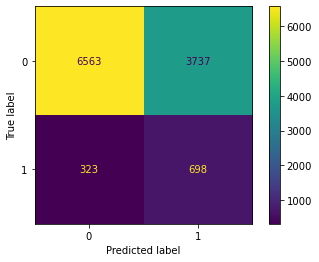

In [84]:
pred = knn_model.predict(X_test)
plot_confusion(y_test,pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### KNN Impalanced

In [85]:
knn_model, _, _,_  = knn_clf(X_imp, X_valid, Y_imp, y_valid, best_k, plot = False)

Test Accuracy:0.9098136207048847
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10300
           1       0.00      0.00      0.00      1021

    accuracy                           0.91     11321
   macro avg       0.45      0.50      0.48     11321
weighted avg       0.83      0.91      0.87     11321



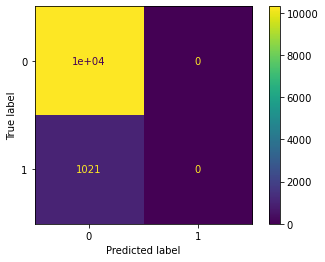

In [86]:
pred = knn_model.predict(X_test)
plot_confusion(y_test,pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### KNN OverSample

In [87]:
knn_model, _, _,_  = knn_clf(X_os, X_valid, Y_os, y_valid, best_k, plot = False)

Test Accuracy:0.5990636869534494
              precision    recall  f1-score   support

           0       0.95      0.59      0.73     10300
           1       0.15      0.71      0.24      1021

    accuracy                           0.60     11321
   macro avg       0.55      0.65      0.49     11321
weighted avg       0.88      0.60      0.68     11321



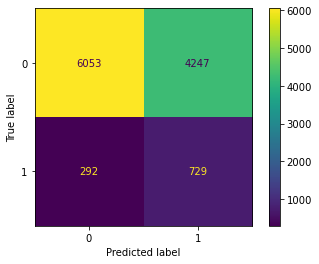

In [88]:
pred = knn_model.predict(X_test)
plot_confusion(y_test,pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### SVM Under Sample

In [89]:
best_model = tune_svm(X_us, X_valid, Y_us, y_valid)

poly 1
poly 2
poly 3
rbf
sigmoid


In [90]:
svm_model, _, _ ,_= svm_clf(X_us, X_valid, Y_us, y_valid,
                        kernel = best_model[0], degree =  best_model[1],c =  best_model[2], plot = False)

Test Accuracy:0.6825368783676353
              precision    recall  f1-score   support

           0       0.95      0.68      0.80     10300
           1       0.17      0.67      0.28      1021

    accuracy                           0.68     11321
   macro avg       0.56      0.68      0.54     11321
weighted avg       0.88      0.68      0.75     11321



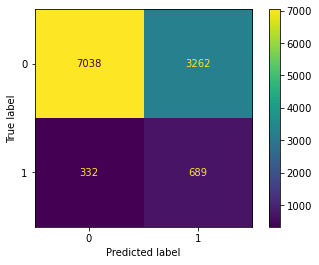

In [91]:
pred = svm_model.predict(X_test)
plot_confusion(y_test,pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### SVM Impalanced data

In [92]:
svm_model, _, _ ,_= svm_clf(X_imp, X_valid, Y_imp, y_valid,
                        kernel = best_model[0], degree =  best_model[1],c =  best_model[2], plot = False)

Test Accuracy:0.9098136207048847
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10300
           1       0.00      0.00      0.00      1021

    accuracy                           0.91     11321
   macro avg       0.45      0.50      0.48     11321
weighted avg       0.83      0.91      0.87     11321



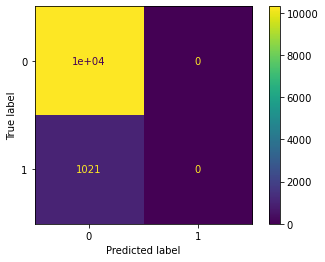

In [93]:
pred = svm_model.predict(X_test)
plot_confusion(y_test,pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### SVM Over sample

In [94]:
svm_model, _, _, _ = svm_clf(X_os, X_valid, Y_os, y_valid,
                        kernel = best_model[0], degree =  best_model[1],c =  best_model[2], plot = False)

Test Accuracy:0.6790919530076849
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     10300
           1       0.18      0.69      0.28      1021

    accuracy                           0.68     11321
   macro avg       0.57      0.68      0.54     11321
weighted avg       0.89      0.68      0.75     11321



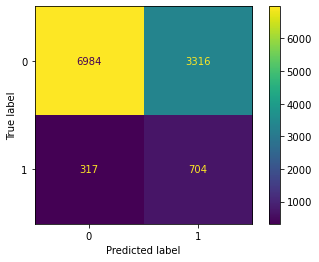

In [95]:
pred = svm_model.predict(X_test)
plot_confusion(y_test,pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### Random Forest UnderSampled

N: 2
N: 7
N: 12
N: 17
N: 22
N: 27
N: 32
N: 37
N: 42
N: 47
N: 52
N: 57


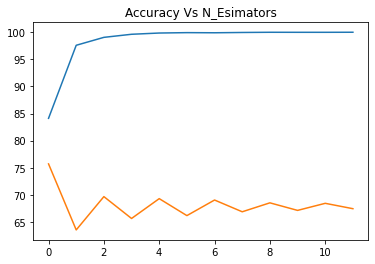

In [96]:
best_esimators = tune_RF(X_us, X_valid, Y_us, y_valid)

In [97]:
rf_model, _, _, _ = RF_clf(X_us, X_valid, Y_us, y_valid, n_esimators = best_esimators, plot= False)

Test Accuracy:0.6867767865029591
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     10300
           1       0.18      0.67      0.28      1021

    accuracy                           0.69     11321
   macro avg       0.56      0.68      0.54     11321
weighted avg       0.88      0.69      0.75     11321



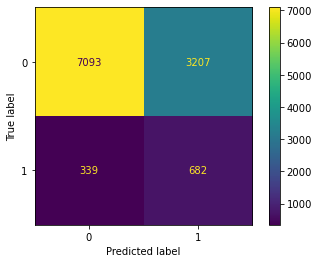

In [98]:
pred = rf_model.predict(X_test)
plot_confusion(y_test,pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

## Random Forest Impalanced


N: 2
N: 7
N: 12
N: 17
N: 22
N: 27
N: 32
N: 37
N: 42
N: 47
N: 52
N: 57
N: 62
N: 67
N: 72
N: 77
N: 82
N: 87
N: 92
N: 97


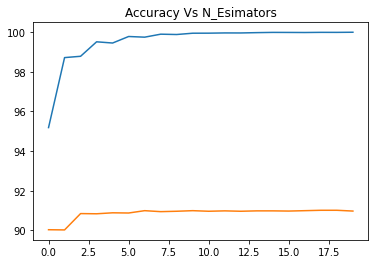

In [99]:
best_esimators = tune_RF(X_imp, X_valid, Y_imp, y_valid)

In [100]:
rf_model, _, _, _ = RF_clf(X_imp, X_valid, Y_imp, y_valid, n_esimators = best_esimators, plot= False)

Test Accuracy:0.8996555074640049
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10300
           1       0.20      0.04      0.06      1021

    accuracy                           0.90     11321
   macro avg       0.56      0.51      0.51     11321
weighted avg       0.85      0.90      0.87     11321



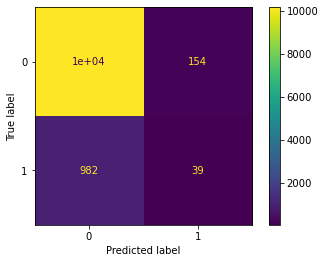

In [101]:
pred = rf_model.predict(X_test)
plot_confusion(y_test,pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))

### Random Forest *OverSampled*

N: 2
N: 7
N: 12
N: 17
N: 22
N: 27
N: 32
N: 37
N: 42
N: 47
N: 52
N: 57


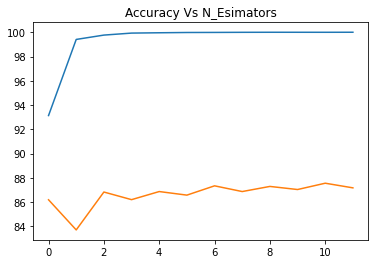

In [102]:
best_esimators = tune_RF(X_os, X_valid, Y_os, y_valid)

In [103]:
rf_model, _, _, _ = RF_clf(X_os, X_valid, Y_os, y_valid, n_esimators = best_esimators, plot= False)

Test Accuracy:0.8576980832081972
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     10300
           1       0.24      0.28      0.26      1021

    accuracy                           0.86     11321
   macro avg       0.59      0.60      0.59     11321
weighted avg       0.87      0.86      0.86     11321



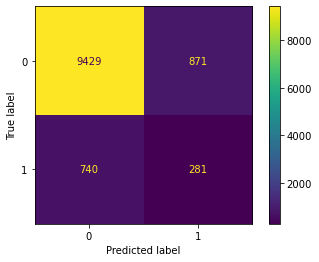

In [104]:
pred = rf_model.predict(X_test)
plot_confusion(y_test,pred)
print(f'Test Accuracy:{(pred == y_test).mean()}')
print(classification_report(y_test,pred))